#### Model output comparison

Models for comparison when setting n_kernels to 2:

- SA-HetMOGP
- HetMOGP

Maybe include:

- A-HetMOGP
- IA-GGP

In [99]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior
from gpytorch.constraints import constraints

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
from modules.cdaf import plot_cdaf
import scipy.stats as st

# set plotting theme
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default,
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/ace0/model"
# save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/"
dpi = 600
savefig = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Setup data

In [100]:
input_set1 = [
    "lognorm_viper_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set2 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
]

input_set3 = [
    "launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set4 = [
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set5 = [
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set6 = [
    "viper_launched",
    "lognorm_viper_briefed_launch_range",
    "lognorm_viper_briefed_evasion_range",
    "cobra_launched",
    "lognorm_cobra_briefed_launch_range",
    "lognorm_cobra_briefed_evasion_range",
]

input_set7 = [
    "norm_viper_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_launch_range",
    "norm_cobra_briefed_evasion_range",
    "briefed_launch_range_diff",
    "briefed_evasion_range_diff",
]

input_set8 = [
    "norm_viper_briefed_launch_range",
    "norm_viper_briefed_evasion_range",
    "norm_cobra_briefed_launch_range",
    "norm_cobra_briefed_evasion_range",
]

viper_portion_cols = [
    'viper_p_NEUTRAL', 
    'viper_p_DEFENSIVE',
    'viper_p_HEADON', 
    'viper_p_OFFENSIVE'
]

cobra_portion_cols = [
    'cobra_p_NEUTRAL', 
    'cobra_p_DEFENSIVE',
    'cobra_p_HEADON', 
    'cobra_p_OFFENSIVE'
]

response1 = ["outcome"]
response2 = ["outcome"] + viper_portion_cols
response3 = ["outcome"] + viper_portion_cols + cobra_portion_cols
response4 = ["outcome"] + viper_portion_cols + cobra_portion_cols + ["viper_launched"] + ["cobra_launched"]

In [101]:
subset_data = .1


path = "../../ace0/msl_evasion-005/msl_evasion-case-5_edited.csv"
df = pd.read_csv(path, index_col=0)

X = torch.tensor(df[input_set8].values, dtype=torch.float)
# Need to torch.float for y, since we have categorical and proportions
y = torch.tensor(df[response4].values, dtype=torch.float)

if not subset_data:
    train_idx, test_idx = torch.utils.data.random_split(X, [.6, .4], \
        generator=torch.Generator().manual_seed(80))
    train_idx, test_idx = train_idx.indices, test_idx.indices

    train_x = X[train_idx,:]
    test_x = X[test_idx,:]
    train_y = y[train_idx,:]
    test_y = y[test_idx,:]
else:
    train_idx = df.groupby('outcome').sample(frac=subset_data, random_state=308).index
    test_idx = np.array(list(set(df.index) - set(train_idx)))
    train_x = X[train_idx,:]
    test_x = X[test_idx,:]
    train_y = y[train_idx,:]
    test_y = y[test_idx,:]

In [102]:
def get_kernel_prod_add(kernel, input_dim, additive, lengthscale_prior=None, period_length_prior=None):
    
    # to compare additive and non-additive model
    if additive:
        ard_num_dims = None
    else:
        ard_num_dims = input_dim
    
    def get_kernel(ks, lengthscale_prior=None):
        batch_shape=torch.Size([1])
        args = {
                "lengthscale_prior":lengthscale_prior,
                "batch_shape":batch_shape,
                "ard_num_dims":ard_num_dims,
            }
        
        # ks: kernel_string
        if ks == "SE":
            return RBFKernel(**args)
        elif ks == "Per":
            args.update({"period_length_prior": period_length_prior})
            return PeriodicKernel(**args)
        elif ks == "M32":
            args.update({"nu": 3/2})
            return MaternKernel(**args)
        elif ks == "M52": 
            args.update({"nu": 5/2})
            return MaternKernel(**args)
        elif ks == "Lin":
            args.pop("lengthscale_prior")
            return LinearKernel(**args)
        elif ks == "PPoly1":
            args.update({"q":1})
            return PiecewisePolynomialKernel(**args)
        elif ks == "PPoly2":
            args.update({"q":2})
            return PiecewisePolynomialKernel(**args)
        elif ks == "PPoly3":
            args.update({"q":3})
            return PiecewisePolynomialKernel(**args)
        else:
            raise ValueError(f"Kernel string {ks} is not a valid kernel.")

    if isinstance(kernel, tuple):
        kernel1, kernel2 = kernel
        k_add = ProductKernel(
            get_kernel(kernel1, lengthscale_prior), 
            get_kernel(kernel2, lengthscale_prior))
    elif isinstance(kernel, str):
        k_add = get_kernel(kernel, lengthscale_prior)
    else:
        raise ValueError("kernel elements must be either string or tuple.")
    return k_add

def get_kernel_combination(kernal_combination: tuple, input_dim, additive=True, lengthscale_prior=None, period_length_prior=None, scale_kernel=False, outputscale_prior=None):
    # kc: kernel combination

    combin = []
    active_dims = []
    k_add = []
    
    active_dim_multiplier = input_dim # determines size of active_dims
    if not additive:
        active_dim_multiplier = 1
        non_additive_dim = list(range(input_dim)) # active_dims for non_additive
    
    for dim in range(active_dim_multiplier):
        for kernel in kernal_combination:
            k_add = get_kernel_prod_add(
                kernel, 
                input_dim=input_dim, 
                additive=additive,
                lengthscale_prior=lengthscale_prior, 
                period_length_prior=period_length_prior
            )
            if scale_kernel:
                outputscale_constraint = constraints.Interval(0,1)
                k_add = ScaleKernel(k_add, outputscale_prior=outputscale_prior, outputscale_constraint=outputscale_constraint)
            combin.append(k_add)
            if additive:
                active_dims.append([dim])
            else:
                active_dims.append(non_additive_dim)
    return combin, active_dims

In [103]:
lmc_coefficients_prior = HorseshoePrior(.5)

gamma_mean = 2.
gamma_var = np.sqrt(2)
alpha = gamma_mean**2 / gamma_var
beta = gamma_mean / gamma_var
lengthscale_prior = GammaPrior(alpha, beta) 

# outputscale_prior = BetaPrior(.15, .15)

In [104]:
kc3 = ("SE", "SE", "SE")
likelihoods = ["Categorical", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
kernel, active_dim = get_kernel_combination(kc3, input_dim=4, lengthscale_prior=lengthscale_prior, additive=True)
model = HetMOGP(
    train_x, num_lpf=16, likelihoods=likelihoods, 
    kernels=kernel, active_dims=active_dim, 
    num_inducing=100, jitter_val = 1e-3, 
    n_compositions=[4, 4], lmc_coefficients_prior=lmc_coefficients_prior,
)

In [105]:
# kc = ("PPoly1", "PPoly1", "PPoly1", "SE", "SE", "SE")

kc = ("SE", "SE", "SE", "SE", "SE", "SE")
likelihoods = ["Categorical", "HetDirichlet", "HetDirichlet", "Bernoulli", "Bernoulli"]
kernel_na, active_dim_na = get_kernel_combination(kc, input_dim=4, lengthscale_prior=lengthscale_prior, additive=False)
model_na = HetMOGP(
    train_x, num_lpf=16, likelihoods=likelihoods, 
    kernels=kernel_na, active_dims=active_dim_na, 
    num_inducing=100, jitter_val = 1e-3, 
    n_compositions=[4, 4], lmc_coefficients_prior=None,
)

In [106]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, neg_elbo):
        if neg_elbo < self.min_validation_loss:
            self.min_validation_loss = neg_elbo
            self.counter = 0
        elif neg_elbo > (self.min_validation_loss * (1+self.min_delta)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [107]:
lrd_num_iter = 700
initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / lrd_num_iter)

In [108]:
def train_model(model, stop_at_iter=None, plot=True, title=None, savefig=False, **kwargs):

    pyro.set_rng_seed(88)
    pyro.clear_param_store()

    num_iter = 3000 
    num_particles = 10

    lrd_num_iter = 700
    initial_lr = 1e-1
    final_lr = 1e-3
    gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
    lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

    optimizer = pyro.optim.ClippedAdam(
        {
            'lr': initial_lr, 
            'lrd': lrd,
            'betas': (0.93, 0.99999), # previously (0.95, 0.999),
            # 'betas': (0.95, 0.999),
            # 'clip_norm': 2.5,
            'clip_norm': .000001,
            # 'clip_norm': .001, # previously 5.0
            # 'clip_norm': 5.0,
            # 'weight_decay': .01,
        }
    )

    loss_array = np.zeros(num_iter)
    iterations_to_converge = 0
    early_stopper = EarlyStopper(patience=100, min_delta=.15)
    # early_stopper = EarlyStopper(patience=50, min_delta=0)
    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
    model.train()
    for i in iterator:
        model.zero_grad()
        loss = svi.step(x=train_x, y=train_y)
        loss_array[i] = loss     
        iterator.set_postfix(loss=loss)
        if stop_at_iter:
            if i >= stop_at_iter:
                break
        else:
            if early_stopper.early_stop(loss) and i >= 100:
                iterations_to_converge = i
                break
    
    if plot:
        fig, ax = plt.subplots(figsize=(5,3.7))
        loss_start = 100
        ax.plot(np.arange(loss_start, i), loss_array[loss_start:i])
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlabel(r"iteration", fontdict={'fontsize':10})
        ax.set_ylabel(r"scaled -ELBO", fontdict={'fontsize':10})
        ax.set_title(title, fontsize=10);
        ax.set_xlim(loss_start-1, i)
        fig.tight_layout()
        
        if savefig:
            filename = kwargs["filename"]
            assert (filename is not None) and (filename[-4:] in [".pdf", ".png"])
            if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
                os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
                print("Deleted file:", filename[:-4] + ".png")
            fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0)
    
    print(f"Iterations to converge: {i}")

Epoch:   0%|          | 0/3000 [00:00<?, ?it/s]

Iterations to converge: 1057


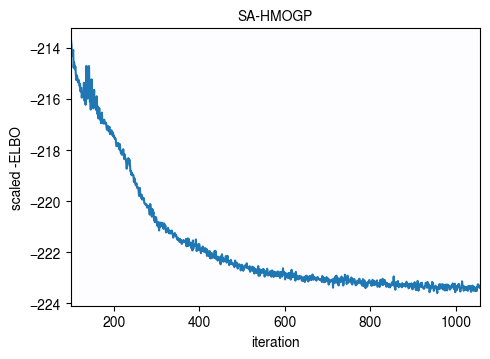

In [109]:
train_model(model, title="SA-HMOGP", savefig=False, filename="elbo_sahmogp.pdf")

Epoch:   0%|          | 0/3000 [00:00<?, ?it/s]

Iterations to converge: 1400


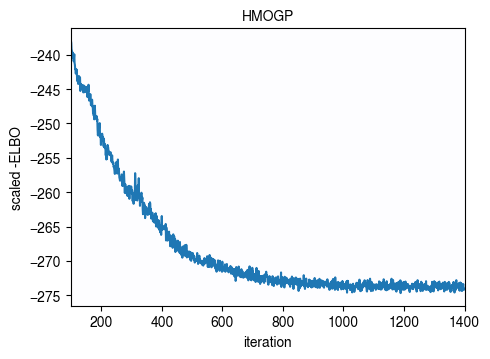

In [110]:
train_model(model_na, stop_at_iter=1400, title="HMOGP", savefig=False, filename="elbo_hmogp.pdf")

In [111]:
def get_predictions_hmogp_example(model, x, n_samples=300):
    
    predictive_dist = Predictive(model.model, guide=model.guide, num_samples=n_samples)
    predictions = predictive_dist(x, None, n_categories=4, n_compositions=[4, 4])
    y0_pred = predictions["hmogp.y_0"].cpu()
    y1_pred = predictions['hmogp.y_1'].cpu()
    y2_pred = predictions['hmogp.y_2'].cpu()
    y3_pred = predictions['hmogp.y_3'].cpu()
    y4_pred = predictions['hmogp.y_4'].cpu()
    f_samples = predictions["hmogp.f(x)"].cpu()
    # y_pred = np.vstack([y0_pred, y1_pred, y2_pred, y3_pred, y4_pred]).T
    y_pred = [y0_pred, y1_pred, y2_pred, y3_pred, y4_pred]

    return y_pred, f_samples

In [112]:
def compute_f_pd_p(
    x, 
    input_dim, 
    lpf_j, # j-th dimension of lpf, j \in {1,...,J}
    ilf, 
    lmc, 
    active_dims, 
    get_indices=True
):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,lpf_j]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

In [113]:
# visualize the result

def plot_additive_ilf(train_x, active_dims, ilf_mean, ilf_lower, ilf_upper, savefig=False, title=None, **kwargs):

    input_dims = train_x.size(-1)
    nrows = ilf_mean.shape[0] // input_dims
    ncols = input_dims
    width = 3.5 * ncols
    height = .9 + 1.1*nrows
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)

    color = "#6F499D"
    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    lw = 1.1
    alpha = .25

    
    for ilf_idx, dim_ in enumerate(active_dims):
        i = ilf_idx % nrows
        j = dim_[0]
        indices = np.argsort(train_x[:,j])

        ax[i,j].plot(train_x[indices,j], ilf_mean[ilf_idx,indices], color=color, alpha=0.9, lw=lw, label="Mean")
        ax[i,j].fill_between(
            train_x[indices,j], ilf_lower[ilf_idx,indices],
            ilf_upper[ilf_idx,indices], alpha=alpha, color=color,
            label="CI region"
        )
        
        ax[i,j].set_xlim([0,1])
        ax[i,j].tick_params(axis='both', which='major', labelsize=12)  # Adjust the size of the ticks
        ax[i,j].set_ylabel(r'$u_{{{}}}^{{({})}}{{(x_{})}}$'.format(ilf_idx+1, j+1, j+1), weight="bold", fontsize=14)
        ax[nrows-1,j].set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=14)
        
        ymin_, ymax_ = ax[i,j].get_ylim()
        if ymin_ < ymin[i]:
            ymin[i] = ymin_
        if ymax_ > ymax[i]:
            ymax[i] = ymax_
            
        if (i == 2) and (j == 1):  # Add the legend to the first subplot only
            ax[i,j].legend(loc='lower left', fontsize=12)  # Adjust the size of the legend font
            
    for i in range(nrows):
        for j in range(ncols):        
            ax[i,j].set_ylim([ymin[i], ymax[i]])        

    fig.suptitle(title, y=1, fontsize=14, weight='bold')
    fig.align_ylabels(ax)
    fig.tight_layout()
    plt.show()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] in [".pdf", ".png"])
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [114]:
# visualize the result

def plot_non_additive_ilf(train_x, active_dims, ilf_mean, ilf_lower, ilf_upper, savefig=False, title=None, **kwargs):

    n_ilf = ilf_mean.size(0)
    nrows = n_ilf
    ncols = np.array(active_dims).max()+1
    width = 3.5 * ncols
    height = .9 + 1.1*nrows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)

    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    color = "#6F499D"
    size = 3
    alpha = .9
    
    for i in range(n_ilf):
        dims = active_dims[i]
        for j in dims:
            indices = np.argsort(train_x[:,j])
            ax[i,j].scatter(train_x[indices,j], ilf_mean[i,indices], alpha=alpha, s=size, color=color, label="Mean")
            ax[i,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.3, color=color,
                # step="mid",
                label="CI region",
            )
            
            ax[i,j].set_xlim([0,1])
            ax[i,j].tick_params(axis='both', which='major', labelsize=12)  # Adjust the size of the ticks
            ax[i,j].set_ylabel(r'$u_{{{}}}({{\mathbf{{x}}}})$'.format(i+1), weight="bold", fontsize=14)
            ax[nrows-1,j].set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=14)
            
            ymin_, ymax_ = ax[i,j].get_ylim()
            if ymin_ < ymin[i]:
                ymin[i] = ymin_
            if ymax_ > ymax[i]:
                ymax[i] = ymax_
                
            if (i == 1) and (j == 1):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font
            
    for i in range(nrows):
        for j in range(ncols):        
            ax[i,j].set_ylim([ymin[i], ymax[i]])        

    fig.align_ylabels(ax)
    fig.suptitle(title, y=1, fontsize=14, weight='bold')
    fig.tight_layout()
    plt.show()

    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] in [".pdf", ".png"])
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [115]:
model.eval()
with torch.no_grad():
    ilf_a = model.variational_strategy.ind_latent_fn
    lmc_coefficients_a = model.variational_strategy.lmc_coefficients.cpu().detach()
    ilf_lower_a, ilf_upper_a = ilf_a.confidence_region()
    ilf_mean_a = ilf_a.mean
    ilf_lower_a, ilf_upper_a, ilf_mean_a = ilf_lower_a.detach().cpu(), ilf_upper_a.detach().cpu(), ilf_mean_a.detach().cpu()

In [116]:
model_na.eval()
with torch.no_grad():
    ilf_na = model_na.variational_strategy.ind_latent_fn
    lmc_coefficients_na = model_na.variational_strategy.lmc_coefficients.cpu().detach()
    ilf_lower_na, ilf_upper_na = ilf_na.confidence_region()
    ilf_mean_na = ilf_na.mean
    ilf_lower_na, ilf_upper_na, ilf_mean_na = ilf_lower_na.detach().cpu(), ilf_upper_na.detach().cpu(), ilf_mean_na.detach().cpu()

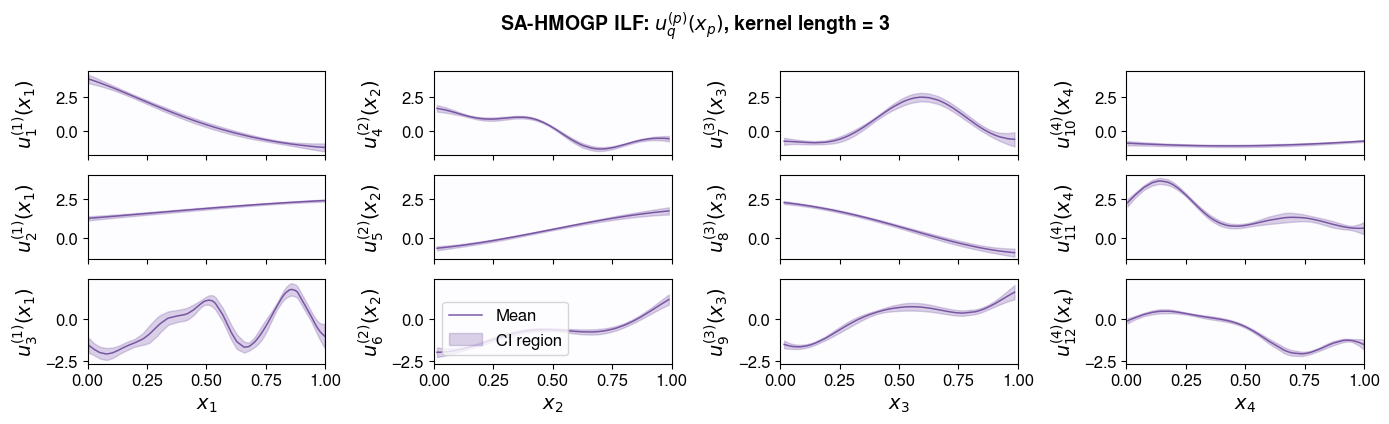

In [117]:
title = "SA-HMOGP ILF: $u_q^{(p)}(x_p)$, kernel length = 3"

plot_additive_ilf(train_x, active_dim, ilf_mean_a, ilf_lower_a, ilf_upper_a, title=title, savefig=False, filename="ilf_sahmogp.pdf")

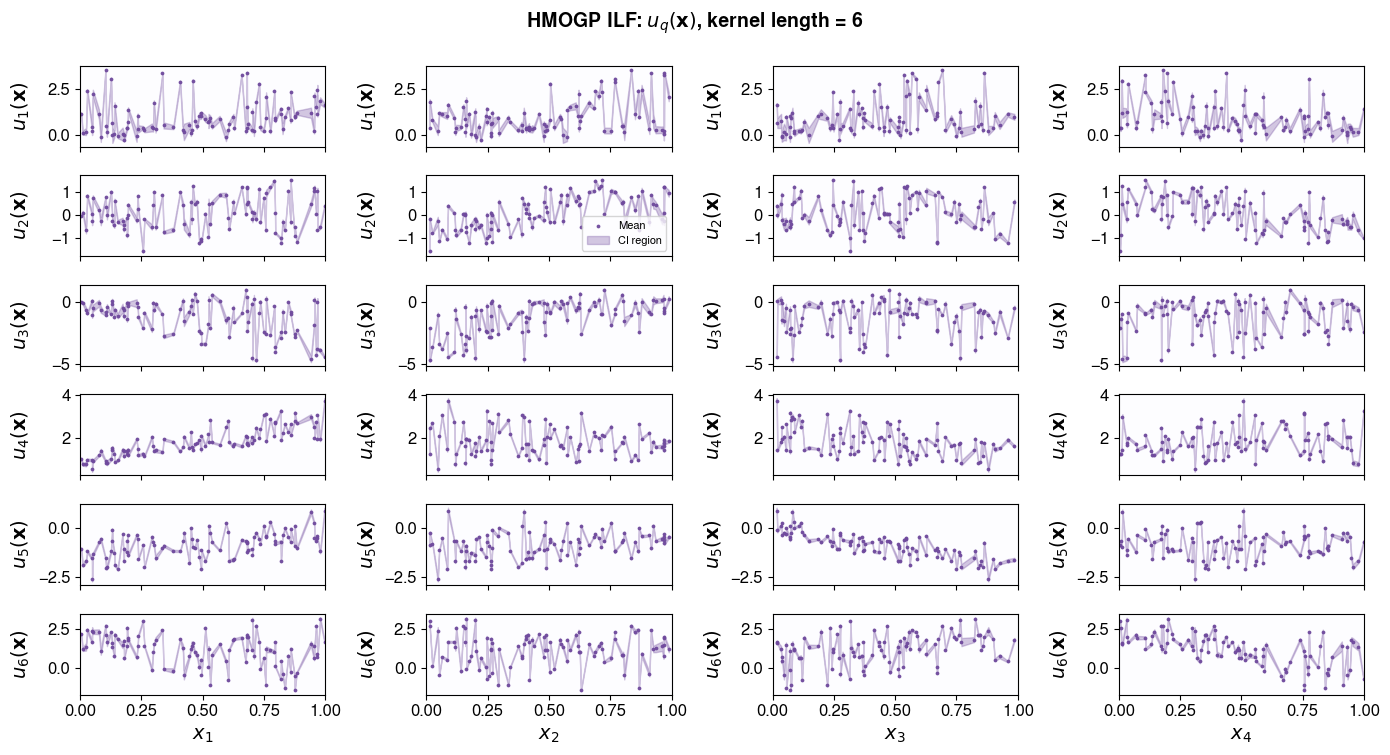

In [118]:
title = "HMOGP ILF: $u_q(\mathbf{x})$, kernel length = 6"
plot_non_additive_ilf(train_x, active_dim_na, ilf_mean_na, ilf_lower_na, ilf_upper_na, title=title, savefig=False, filename="ilf_hmogp.pdf")

In [119]:
blue_briefed_launch_min_max = np.round([df.viper_briefed_launch_range.min(), df.viper_briefed_launch_range.max()], 2)
blue_briefed_evasion_min_max = np.round([df.viper_briefed_evasion_range.min(), df.viper_briefed_evasion_range.max()], 2)
red_briefed_launch_min_max = np.round([df.cobra_briefed_launch_range.min(), df.cobra_briefed_launch_range.max()], 2)
red_briefed_evasion_min_max = np.round([df.cobra_briefed_evasion_range.min(), df.cobra_briefed_evasion_range.max()], 2)

In [120]:
y_pred_a, f_samples_a = get_predictions_hmogp_example(model, test_x, n_samples=300)

In [121]:
y_pred_na, f_samples_na = get_predictions_hmogp_example(model_na, test_x, n_samples=300)

In [169]:
from matplotlib.gridspec import GridSpec
from scipy.signal import argrelextrema, argrelmin, argrelmax
def plot_ahetmogp(
    train_x, 
    test_x, 
    test_y,
    output_d,
    likelihood, 
    lpf_d, 
    ilf_mean,
    ilf_lower,
    ilf_upper,
    lmc_coefficients,
    active_dims,
    y_pred=None,
    additive=True,
    title=None,
    y_pred_from_true_lpf=None,
    plot_obs=False,
    plot_scatter_2d=False,
    savefig=False,
    ulpf = False,
    row_label=None,
    input_label=None,
    response_label=None,
    vlines: dict=None,
    height_adj=0,
    **kwargs,
):
    
    
        
    lpf_Jd = get_num_lpf(likelihood, **kwargs)

    # setup categorical plots
    has_categorical = likelihood in ["Bernoulli", "Categorical", "OrderedLogistic",]
    has_categorical_plot = has_categorical*plot_obs
    nobrows = plot_obs + has_categorical_plot + plot_scatter_2d*2
    categorical_row = lpf_Jd*has_categorical_plot
    categorical_row2 = categorical_row + 2
    n_categories = int((test_y[:,output_d].max()+1)*(has_categorical_plot))
    
    nrows = lpf_Jd + nobrows
    ncols = train_x.size(-1)
    width = 3.5 * ncols
    height = .9 + 1.1*nrows + .90*(has_categorical_plot) + .05*n_categories + 1.25*(plot_scatter_2d) + height_adj
    # fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)
    fig = plt.figure(figsize=(width, height))
    gs = GridSpec(nrows, ncols, figure=fig)
    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    lw = 1.1

    color = "#6F499D"
    color_test = "#EE6C00"
    color_ahmogp = "#6F499D"

    axs = []
    
    title_fs = 14
    tick_fs = 12
    xlabel_fs = 14
    ylabel_fs = 14
    legend_fs = 11
    annotate_fs = 14
    vlines_fs = 10
    matrix_custom = [[None]*ncols for _ in range(lpf_Jd)]
    if vlines is not None:
        assert {"subplot"}.issubset(vlines.keys())
        matrix = [[None]*ncols for _ in range(lpf_Jd)]
        if "order" in vlines.keys():
            order = vlines["order"]
        elif "window" in vlines.keys():
            order = int(train_x.size(0) / ((train_x.max() - train_x.min()) / vlines["window"]))
        else:
            order = 25
        
        if "xticks" in vlines.keys():    
            matrix_custom = vlines["xticks"]
            assert (len(matrix_custom) == lpf_Jd) and (len(matrix_custom[0]) == ncols)
            
        indices_no_edge = lambda x: (0.05 < x) & (x < 0.95)

    for i in range(nrows):     
        for j in range(ncols):  
            if (i <= (lpf_Jd-1)) or (plot_obs == False):
                ax = fig.add_subplot(gs[i,j])    
                d_j = lpf_d+i              
                # lpf have to use train_x, but ppc on observations can be based on test_x
                indices, ulpf_mean = compute_f_pd_p(train_x, j, d_j, ilf_mean, lmc_coefficients, active_dims)
                _, ulpf_lower = compute_f_pd_p(train_x, j, d_j, ilf_lower, lmc_coefficients, active_dims)
                _, ulpf_upper = compute_f_pd_p(train_x, j, d_j, ilf_upper, lmc_coefficients, active_dims)
                
                lpf_mean = transform_ulpf(likelihood, i, ulpf_mean)
                lpf_lower = transform_ulpf(likelihood, i, ulpf_lower)
                lpf_upper = transform_ulpf(likelihood, i, ulpf_upper)
                
                if (likelihood == "HetDirichlet") and (i == lpf_Jd-1):
                    lpf_mean = lpf_mean.exp()
                    lpf_lower = lpf_lower.exp()
                    lpf_upper = lpf_upper.exp()
                
                if additive:
                    ax.plot(train_x[indices,j], lpf_mean, color=color, alpha=0.9, lw=lw, label="Mean")
                else:
                    ax.scatter(train_x[indices,j], lpf_mean, color=color, alpha=0.9, s=3, label="Mean")
                    
                ax.fill_between(
                    train_x[indices,j], lpf_lower,
                    lpf_upper, alpha=.25, color=color,
                    label="CI region"
                )
                
                if vlines is not None:
                    if [i,j] in vlines["subplot"]:
                        x_ = train_x[indices,j].clone()
                        lpf_ = lpf_mean.numpy().copy()
                        idx = indices_no_edge(x_)
                        x_ = x_[idx]
                        lpf_ = lpf_[idx]

                        minima = argrelmin(lpf_, order=order)[0]
                        maxima = argrelmax(lpf_, order=order)[0]
                        relextremas = np.concatenate([minima, maxima]).flatten()
                        relextremas_x = x_[relextremas]
                        relextremas_y = np.interp(relextremas_x, x_, lpf_)
                        matrix[i][j] = np.stack([relextremas_x,relextremas_y])
                    
                    if matrix_custom[i][j] is not None:
                        x_ = np.array(matrix_custom[i][j])
                        y_ = np.interp(x_, train_x[indices,j], lpf_mean.numpy())
                        matrix_custom[i][j] = np.stack([x_, y_])
                
                if not ulpf:
                    if additive:
                        ylabel = r'$\tilde{{f}}_{{{},{}}}^{{~({})}}$'.format(output_d+1, i+1, j+1)
                    else:
                        ylabel = r'$\tilde{{f}}_{{{},{}}}$'.format(output_d+1, i+1)
                else:
                    if additive:
                        ylabel = r'$f_{{{},{}}}^{{~({})}}$'.format(output_d+1, i+1, j+1)
                    else:
                        ylabel = r'$f_{{{},{}}}$'.format(3, 5)
                ax.set_ylabel(ylabel, weight="bold", fontsize=ylabel_fs)
                axs.append(ax)
            elif plot_obs:
                if has_categorical:
                    plot_cm = False
                    plot_two_cm = y_pred_from_true_lpf is not None
                    if (j <= 1) and (i == categorical_row):
                        y_ = y_pred[output_d]
                        subtitle = "Confusion matrix: predicted density \n from estimated LPF"
                        if (plot_two_cm) and (j == 0):
                            k = 0
                            y_ = y_pred_from_true_lpf
                            subtitle = "Confusion matrix: predicted density \n from true LPF"
                            plot_cm = True  
                        elif (plot_two_cm) and (j == 1):
                            plot_cm = True  
                        elif (not plot_two_cm) and (j == 0):
                            plot_cm = True
                        if plot_cm: 
                            ax_cat = fig.add_subplot(gs[categorical_row:categorical_row2,j])  
                            cm = confusion_matrix(test_y[:,output_d], y_)
                            ax_cat.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
                            for ii in range(cm.shape[0]):
                                for jj in range(cm.shape[1]):
                                    ax_cat.text(x=jj, y=ii,s=cm[ii, jj], va='center', ha='center', size=annotate_fs)
                            ax_cat.tick_params(axis='both', which='major', labelsize=tick_fs) 
                            ax_cat.set_ylabel("True", fontsize=ylabel_fs)
                            ax_cat.set_xlabel("Predicted", fontsize=xlabel_fs)
                            ax_cat.set_title(subtitle, fontsize=title_fs)
                            ax_cat.xaxis.set_ticks_position('bottom')
                    elif (plot_scatter_2d) and (i == categorical_row2) and (j <= 1):
                        if j == 0:
                            y_ = test_y
                            marker = "o"
                            s = 5
                            subtitle = "Test data"
                        elif j == 1:
                            y_ = torch.tensor(y_pred)
                            s = 7
                            marker = "x"
                            subtitle = "Predicted data"
                        ax_cat = fig.add_subplot(gs[categorical_row2:,j])  
                        idx_labels = []
                        for k in range(n_categories):
                            idx = (y_[:,output_d]==k).nonzero().flatten()
                            idx_labels.append(idx)
                        for k, idx in enumerate(idx_labels):                            
                            ax_cat.scatter(test_x[idx,0], test_x[idx,1], s=s, alpha=1, label=r'$y_{{{}}}={{{}}}$'.format(output_d+1, k), marker=marker)

                        if j == 0:
                            ax_cat.legend(fontsize=legend_fs)
                        ax_cat.set_title(subtitle, fontsize=title_fs)
                        ax_cat.set_xlabel(r'$x_1$', weight="bold", fontsize=xlabel_fs)
                        ax_cat.set_ylabel(r'$x_2$', weight="bold", fontsize=ylabel_fs)
                        ax_cat.tick_params(axis='both', which='major', labelsize=tick_fs)  
                else:
                    ax = fig.add_subplot(gs[i,j])
                    alpha_test = .6
                    alpha_pred = .9
                    ax.scatter(test_x[:,j], test_y[:,output_d], alpha = alpha_test, label='Test data', s=5, color=color_test)
                    ax.scatter(test_x[:,j], y_pred[:,output_d], alpha = alpha_pred, label='Predictions', s=7, color=color_ahmogp, marker="x")
                    ax.set_ylabel(f'$y_{output_d+1}$', fontsize=ylabel_fs)  # Add the y label using LaTeX
                    if j==0:  # Add the legend to the first subplot only
                        ax.legend(fontsize=legend_fs)  # Adjust the size of the legend font
                    axs.append(ax)
            ax.set_xlim([0,1])
            ax.tick_params(axis='both', which='major', labelsize=tick_fs)  # Adjust the size of the ticks
            # set x_label on the last relevant row
            if i == max(categorical_row-1, (not has_categorical_plot)*(nrows-1)):   
                if input_label:         
                    ax.set_xlabel(r'$x_{{{}}}:$ {}'.format(j+1, input_label[j]), weight="bold", fontsize=xlabel_fs)
                else:
                    ax.set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=xlabel_fs)
            
            ymin_, ymax_ = ax.get_ylim()
            if ymin_ < ymin[i]:
                ymin[i] = ymin_
            if ymax_ > ymax[i]:
                ymax[i] = ymax_
    
    # axs_find_minmax = axs
    # if plot_obs and not has_categorical:
    #     axs_find_minmax = axs_find_minmax[:-1]
    
    for i_, ax in enumerate(axs):
        i = i_ // ncols
        j = i_ % ncols
        ax.set_ylim([ymin[i], ymax[i]])
        if i < (nrows-1):
            ax.set_xticklabels([])
        
        if vlines is not None:
            if (matrix[i][j] is not None) or (matrix_custom[i][j] is not None):
                if (matrix[i][j] is not None) and (matrix_custom[i][j] is not None):
                    x1, y1 = matrix[i][j]
                    x2, y2 = matrix_custom[i][j]
                    x = np.concatenate([x1,x2])
                    y = np.concatenate([y1,y2])
                elif matrix[i][j] is not None:
                    x, y = matrix[i][j]
                else:
                    x, y = matrix_custom[i][j]
                
                if j < 2:
                    color = "blue"
                else:
                    color = "red"
                    
                ax.vlines(x, ymin=ax.get_ylim()[0], ymax=y, colors=color, linestyles='dotted', lw=1, alpha=.95)
                
                for x_, y_ in zip(x, y):            
                    if "transform" in vlines.keys():
                        text = np.int64(unnormalise(x_, *vlines["transform"][j]))
                    else:
                        text = np.round(x_,2)

                    ha = "left"
                    xpad = 1.5

                    ax.annotate(text, (x_, ax.get_ylim()[0]), c=color, ha=ha, va='bottom', fontsize=vlines_fs, alpha=.99, textcoords="offset points", xytext=(xpad, 0))
                
            
        # if vlines is not None:
        #     if [i,j] in vlines["subplot"]:
        #         xticks_subplot = vlines["subplot"]                            
        #         subplot_idx = np.where([xticks_subplot[subplot_index] == [i,j] for subplot_index in range(len(xticks_subplot))])[0][0]                       
        #         xticks = vlines["xticks"][subplot_idx]
        #         y_values = vlines["yvalues"][subplot_idx]
        #         vline = ax.vlines(xticks, ymin=ax.get_ylim()[0], ymax=y_values, colors=vlines["color"][subplot_idx], linestyles='dotted', lw=1, alpha=.95)
        #         for xtick in xticks:
        #             if xtick > .5:
        #                 ha = "right"
        #                 xpad = -1
        #             else:
        #                 ha = "left"
        #                 xpad = 1
                        
        #             if "transform" in vlines.keys():
        #                 text = np.int64(unnormalise(xtick, *vlines["transform"][subplot_idx]))
        #             else:
        #                 text = np.round(xtick,2)
                    
        #             ax.annotate(text, (xtick, ax.get_ylim()[0]), c=vlines["color"][subplot_idx], ha=ha, va='bottom', fontsize=vlines_fs, alpha=.99, textcoords="offset points", xytext=(xpad, 0))
            
    if title is None:
        if not ulpf:
            if additive:
                title = r"Additive LPF $\tilde{{\mathbf{{f}}}}_{{{}}}$".format(output_d+1)
            else:
                title = r"Non-additive LPF $\tilde{{\mathbf{{f}}}}_{{{}}}$".format(output_d+1)
        else:
            if additive:
                title = r"Additive ULPF $\mathbf{{f}}_{{{}}}$".format(output_d+1)
            else:
                title = r"Non-additive ULPF $\mathbf{{f}}_{{{}}}$".format(output_d+1)
        add_title = ""
        if plot_obs:
            add_title = r" and ppc from $y_{} \sim ${}$(\tilde{{\mathbf{{f}}}}_{{{}}})$".format(output_d+1, likelihood, output_d+1)
        title += add_title
    if response_label:
        title = title + r" for " + response_label
    fig.suptitle(title, fontsize=title_fs)
    fig.tight_layout()
    
    if row_label:
        pad = 20 # in points
        for i_, ax in enumerate(axs):
            i = i_ % ncols
            k = i_ // ncols
            if i == 0:
                ax.annotate(row_label[k], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size=annotate_fs, ha='center', va='center', rotation=90, weight="bold")        

    fig.align_ylabels(axs)
    fig.tight_layout()
    plt.show()

    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] in [".pdf", ".png"])
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [123]:
def get_num_lpf(likelihood, **kwargs):
    n_categories = None
    n_compositions = 0
    if likelihood == "Categorical":
        n_categories = kwargs["n_categories"]
    if likelihood == "HetDirichlet":
        n_compositions = kwargs["n_compositions"]
    if likelihood == "Dirichlet":
        n_compositions = kwargs["n_compositions"]
    
    likelihood_lpf_dict = {
        "HetNormal": 2,
        "Poisson": 1,
        "Bernoulli": 1,
        "Categorical": n_categories,
        "OrderedLogistic": 1,
        "Dirichlet": n_compositions,
        "HetDirichlet": n_compositions + 1,
    }
    return likelihood_lpf_dict[likelihood]

def get_observation_dim(likelihood, **kwargs):
    n_categories = 0
    n_compositions = 0
    if "n_categories" in kwargs.keys():
        n_categories = kwargs["n_categories"]
    if "n_compositions" in kwargs.keys():
        n_compositions = kwargs["n_compositions"]
    
    likelihood_lpf_dict = {
        "HetNormal": 2,
        "Poisson": 1,
        "Bernoulli": 1,
        "Categorical": n_categories,
        "OrderedLogistic": 1,
        "HetDirichlet": n_compositions,
    }
    return likelihood_lpf_dict[likelihood]

def transform_ulpf(
    likelihood, 
    j, # the j-th lpf of lpf_d
    ulpf,
    **kwargs
):
    # j = 0 for Categorical
    if likelihood in ["Categorical", "HetDirichlet"]:
        j = 0
    
    response_fn_dict = {
        "HetNormal": {"0": ulpf, "1": torch.exp(ulpf)},
        "Poisson": {"0": torch.exp(ulpf)},
        "Bernoulli": {"0": ulpf},
        "Categorical": {"0": ulpf},
        "OrderedLogistic": {"0": ulpf},
        "HetDirichlet": {"0": ulpf},
    }
    return response_fn_dict[likelihood][str(j)]

In [124]:
def unnormalise(xnorm, xmin, xmax):
    x = xnorm*(xmax-xmin) + xmin
    return np.round(x, 2)

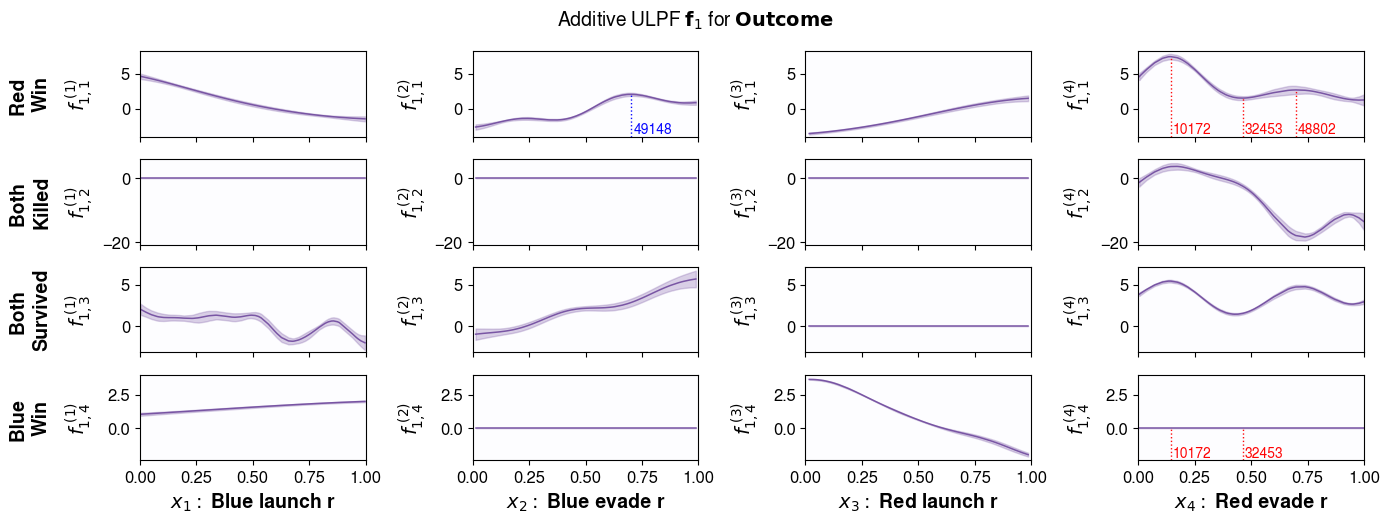

In [125]:


# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"

outcome = [
    "Red \nWin",
    "Both \nKilled",
    "Both \nSurvived",
    "Blue \nWin",
]

input_set = [
    'Blue launch r',
    'Blue evade r',
    'Red launch r',
    'Red evade r'
]

response_label = r"$\bf{Outcome}$"

# vlines = {
#     "subplot": [[0,1], [0,3], [3,1], [3,2]], 
#     "xticks": [[0.3319], [0.0968, 0.6445], [0.6867], [0.0721]],
#     "transform": [blue_briefed_evasion_min_max, red_briefed_evasion_min_max, blue_briefed_evasion_min_max, red_briefed_launch_min_max],
#     "print_extrema": False,
#     "color": ["blue", "red", "blue", "red"]
# }


vlines = {
    "subplot": [[0,0], [0,1], [0,3], 
                [3,2], [3,1], [3,3]], 
    "transform": [
        blue_briefed_launch_min_max, 
        blue_briefed_evasion_min_max, 
        red_briefed_launch_min_max, 
        red_briefed_evasion_min_max
        ],
    "window": .33
    # "window": .41
}

plot_ahetmogp(train_x, test_x, test_y, 0, "Categorical", 0, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dim, n_categories=4, title=None, plot_obs=False, ulpf=True, row_label=outcome, input_label=input_set, response_label=response_label, savefig=False, filename="outcome_sahmogp.pdf", vlines=vlines)

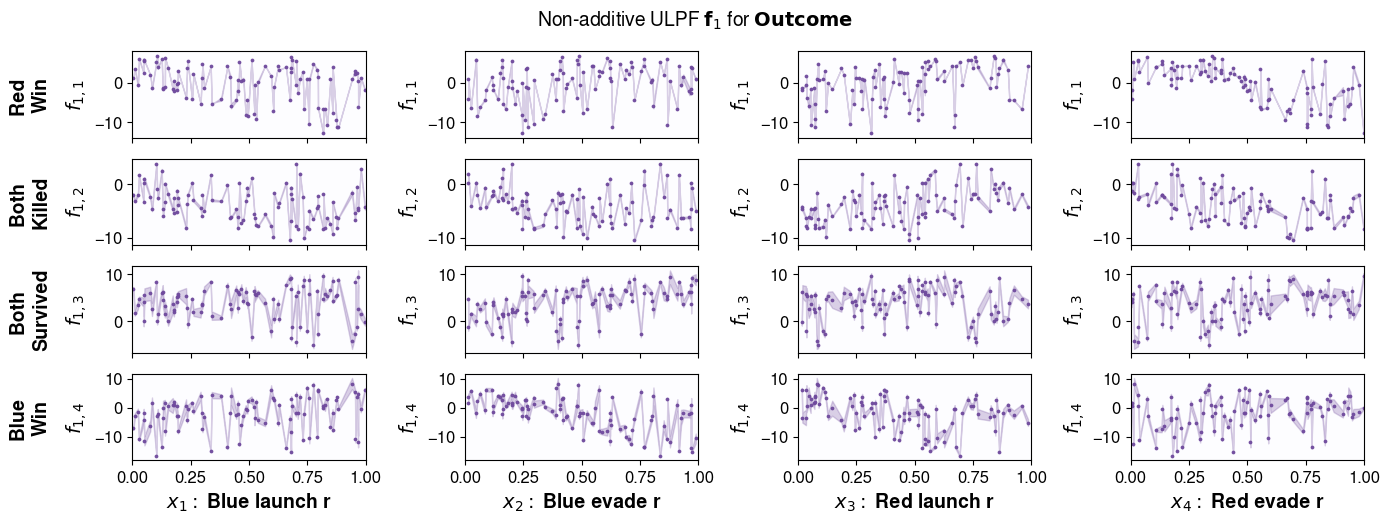

In [126]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, 0, "Categorical", 0, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_categories=4, additive=False, ulpf=True, row_label=outcome, input_label=input_set, response_label=response_label, title=None, plot_obs=False, savefig=False, filename="outcome_hmogp.pdf",)

In [127]:

def plot_cm(test_y, y_pred_a, y_pred_na, labels=None, savefig=False, **kwargs):

    n_categories = test_y.max() + 1
    width = 3.5 * 2
    height = .9 + 1.1*1 + .90 + .25*n_categories
    
    y_pred_a = y_pred_a.median(0)[0].squeeze(0)
    y_pred_na = y_pred_na.median(0)[0].squeeze(0)
    
    cm_a = confusion_matrix(test_y, y_pred_a)
    cm_na = confusion_matrix(test_y, y_pred_na)
    cm_list = [cm_a, cm_na]

    fig, ax = plt.subplots(ncols=2, figsize=(width, height))

    for i, cm in enumerate(cm_list):
        
        if i == 0:
            subtitle = "SA-HMOGP \nkernel length = 3"
        else:
            subtitle = "HMOGP \nkernel length = 6"
        
        ax[i].matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
        for ii in range(cm.shape[0]):
            for jj in range(cm.shape[1]):
                ax[i].text(x=jj, y=ii,s=cm[ii, jj], va='center', ha='center', size=10)
        ax[i].tick_params(axis='both', which='major', labelsize=9) 
        ax[i].set_ylabel("True", fontsize=9)
        
        ax[i].set_title(subtitle, fontsize=9, weight='bold')
        ax[i].xaxis.set_ticks_position('bottom')
    
        pi = np.round(scotts_pi(cm, weight_type="quadratic"),2)
        # ax[i].annotate(f"Scott's Pi: {pi}", textcoords="offset points", ha="center", va="top", fontsize=10, xycoords="axes points", xy=(34,-20))
        ax[i].set_xlabel(f"\nPredicted \nScott's Pi: {pi}", fontsize=9)
        
        if labels:
            ax[i].set_yticks(np.arange(len(labels)))
            ax[i].set_yticklabels(labels)
            ax[i].set_xticks(np.arange(len(labels)))
            ax[i].set_xticklabels(labels)
    
    fig.tight_layout()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".pdf") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [128]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    
    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [129]:

def plot_ppc_dirichlet(test_x, input_dim, test_y, y_pred, output_d, ax, y_pred_na=None, **kwargs):
    
    assert test_y.shape[-1] == y_pred.shape[-1]
    
    test_y = test_y[...,output_d]    
    y_pred = y_pred[...,output_d]
    idx = np.argsort(test_x[:,input_dim])
    lower, mean, upper = percentiles_from_samples(y_pred)
    lower, mean, upper = lower.squeeze(0), mean.squeeze(0), upper.squeeze(0)
    
    # fig, ax = plt.subplots(figsize=(15,4))

    # ax.fill_between(
    #     test_x[idx,input_dim], lower[idx],
    #     upper[idx], alpha=0.1, color='grey', 
    #     edgecolor="k",
    #     lw=1,
    # )
    
    # 

    ax.scatter(x=test_x[idx,input_dim], y=test_y, s=8, color='red', alpha=.9, label="Actual")
    # ax.scatter(x=test_x[idx,input_dim], y=mean[idx], s=15, color='k', alpha=.9, marker="x")
    scatter = ax.scatter(x=test_x[idx,input_dim], y=mean[idx], s=17, alpha=.9, marker="x", label="PPD Mean", **kwargs)
    color = scatter.get_facecolor()
    
    ax.fill_between(
        test_x[idx,input_dim], lower[idx],
        upper[idx], alpha=0.1, lw=1, color=color,
        edgecolor="k",
        label="PPD CI"
    )
    
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    # fig.tight_layout()
    # plt.show()

In [130]:
save_image_path

'/mnt/c/Users/huyca/OneDrive/Thesis_tex/'

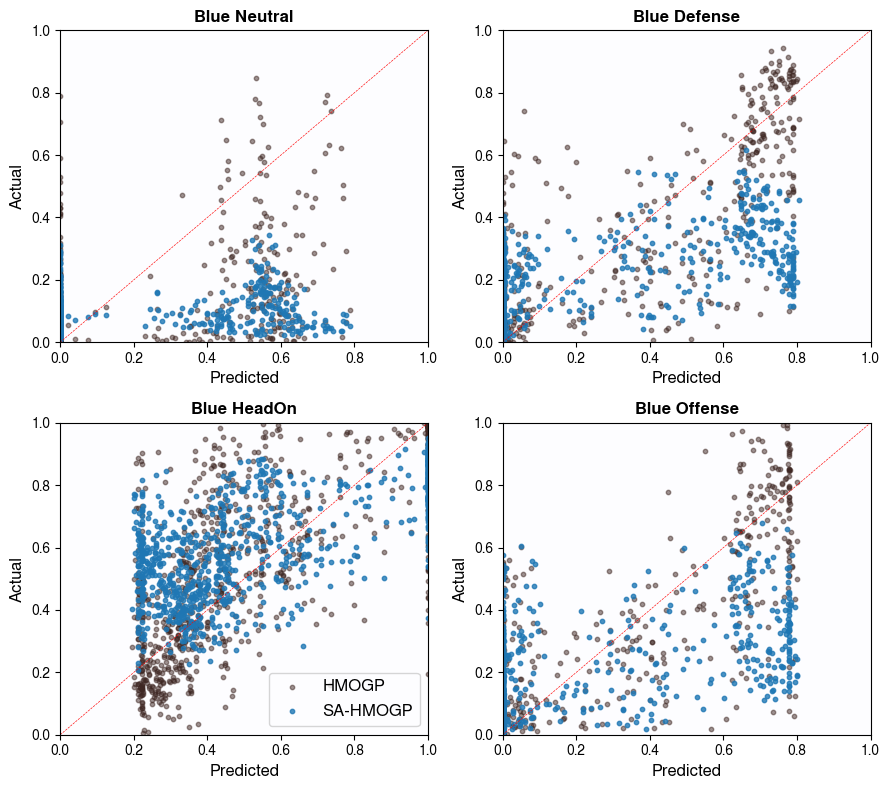

In [131]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8))


blue_portion_cols = [
    'Blue Neutral', 
    'Blue Defense',
    'Blue HeadOn', 
    'Blue Offense',
]
k = 0
for i in range(2):
    for j in range(2):
        ax[i,j].scatter(x=test_y[:,k+1], y=y_pred_na[1].mean(0).squeeze(0)[:,k], s=10, alpha=.5, c='#3E2723', label="HMOGP")
        ax[i,j].scatter(x=test_y[:,k+1], y=y_pred_a[1].mean(0).squeeze(0)[:,k], s=10, alpha=.8, label="SA-HMOGP")
        x = np.linspace(0,1,100)
        y = x
        ax[i,j].plot(x,y, lw=.45, ls="--", c="red", alpha=.99)
        ax[i,j].set_xlim(0,1)
        ax[i,j].set_ylim(0,1)
        ax[i,j].tick_params(axis="both", which="major", labelsize=10)
        ax[i,j].set_xlabel("Predicted", fontsize=12)
        ax[i,j].set_ylabel("Actual", fontsize=12)
        
        ax[i,j].set_title(f"{blue_portion_cols[k]}", fontsize=12, weight="bold")
        k += 1
ax[1,0].legend(fontsize=12, loc="lower right")       
fig.tight_layout()

if savefig:
    filename = "blue_composition_pred_actual.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

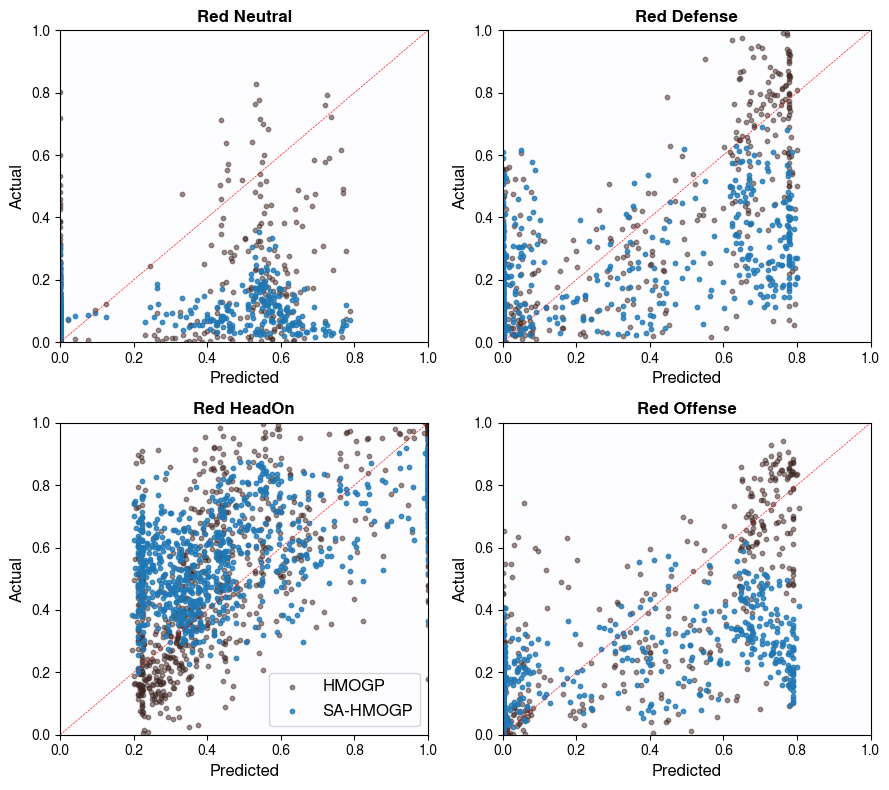

In [132]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,8))


red_portion_cols = [
    'Red Neutral', 
    'Red Defense',
    'Red HeadOn', 
    'Red Offense',
]

k = 0
for i in range(2):
    for j in range(2):
        ax[i,j].scatter(x=test_y[:,k+5], y=y_pred_na[2].mean(0).squeeze(0)[:,k], s=10, alpha=.5, c='#3E2723', label="HMOGP")
        ax[i,j].scatter(x=test_y[:,k+5], y=y_pred_a[2].mean(0).squeeze(0)[:,k], s=10, alpha=.8, label="SA-HMOGP")
        x = np.linspace(0,1,100)
        y = x
        ax[i,j].plot(x,y, lw=.45, ls="--", c="red", alpha=.99)
        ax[i,j].set_xlim(0,1)
        ax[i,j].set_ylim(0,1)
        ax[i,j].tick_params(axis="both", which="major", labelsize=10)
        ax[i,j].set_xlabel("Predicted", fontsize=12)
        ax[i,j].set_ylabel("Actual", fontsize=12)
        
        ax[i,j].set_title(f"{red_portion_cols[k]}", fontsize=12, weight="bold")
        k += 1
ax[1,0].legend(fontsize=12, loc="lower right")       
fig.tight_layout()

if savefig:
    filename = "red_composition_pred_actual.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

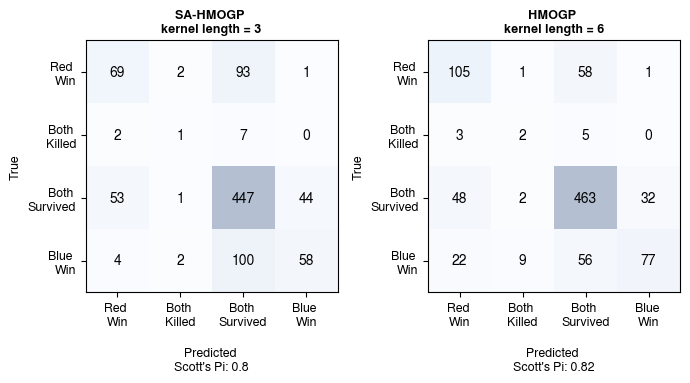

In [133]:
outcome = [
    "Red \nWin",
    "Both \nKilled",
    "Both \nSurvived",
    "Blue \nWin",
]

plot_cm(test_y[:,0], y_pred_a[0], y_pred_na[0], labels=outcome, savefig=False, filename="outcome_cm.pdf")

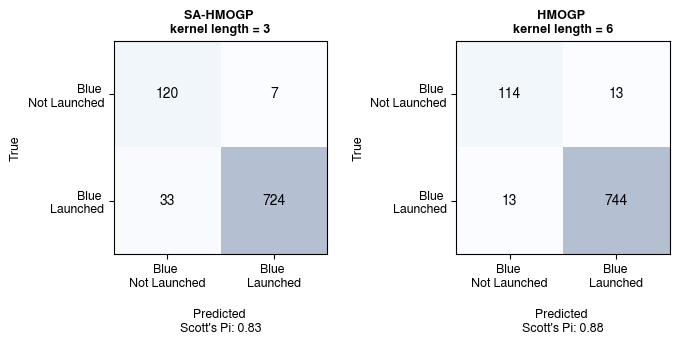

In [134]:
label = ["Blue \nNot Launched", "Blue \nLaunched"]
plot_cm(test_y[:,9], y_pred_a[3], y_pred_na[3], labels=label, savefig=False, filename="blue_launched_cm.pdf")

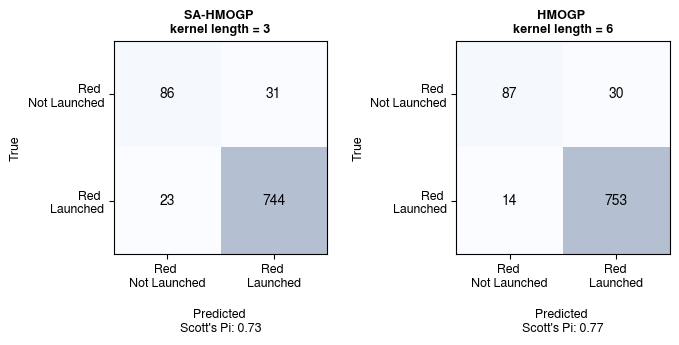

In [135]:
label = ["Red \nNot Launched", "Red \nLaunched"]
plot_cm(test_y[:,10], y_pred_a[4], y_pred_na[4], labels=label, savefig=False, filename="red_launched_cm.pdf")

In [136]:
# y_pred_dim = 
# 'Categorical': 0:1,
# 'HetDirichlet': 1:2,
# 'HetDirichlet': 2:3,
# 'Bernoulli': 3:4,
# 'Bernoulli': 4:5,

# y_dim = 
# 'Categorical': 0:1,
# 'HetDirichlet': 1:5,
# 'HetDirichlet': 5:9,
# 'Bernoulli': 9:10,
# 'Bernoulli': 10:11,

In [137]:
# n_lpf = 
# 'Categorical': 0:4,
# 'HetDirichlet': 4:9,
# 'HetDirichlet': 9:14,
# 'Bernoulli': 14:15,
# 'Bernoulli': 15:16,

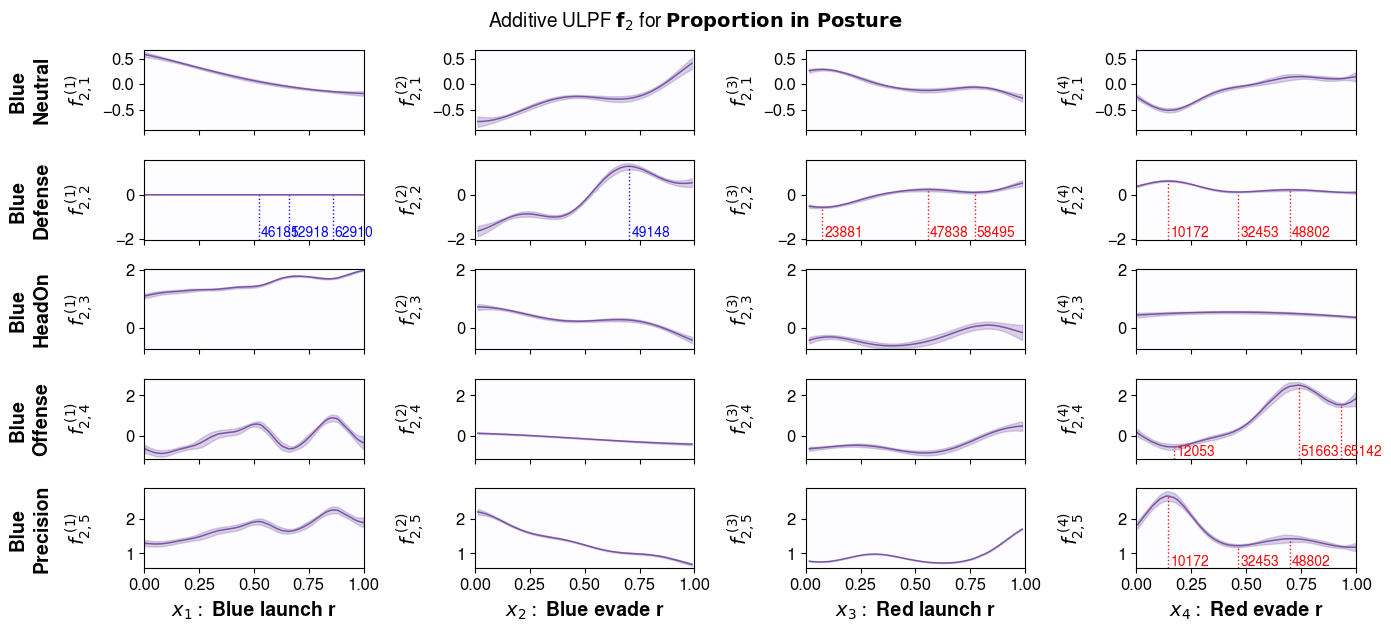

In [138]:


# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"

blue_portion_cols = [
    'Blue \nNeutral', 
    'Blue \nDefense',
    'Blue \nHeadOn', 
    'Blue \nOffense',
    'Blue \nPrecision'
]

red_portion_cols = [
    'Red \nNeutral', 
    'Red \nDefense',
    'Red \nHeadOn', 
    'Red \nOffense',
    'Red \nPrecision'
]

input_set = [
    'Blue launch r',
    'Blue evade r',
    'Red launch r',
    'Red evade r',
]

response_label = r"$\bf{Proportion ~ in ~ Posture}$"
xticks = [[None]*4 for _ in range(5)]
xticks[3][0] = [.38]
vlines = {
    "subplot": [
        [1,0], [1,1], [1,2], [1,3],
        [3,1], [3,3],
        [4,1], [4,3],
        ], 
    "transform": [
        blue_briefed_launch_min_max, 
        blue_briefed_evasion_min_max, 
        red_briefed_launch_min_max, 
        red_briefed_evasion_min_max
        ],
    "window": .25,
    # "xticks": xticks
}

plot_ahetmogp(train_x, test_x, test_y, 1, "HetDirichlet", 4, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dim, n_compositions=4, additive=True, title=None, ulpf=True, row_label=blue_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="blue_composition_sahmogp.pdf", vlines=vlines)

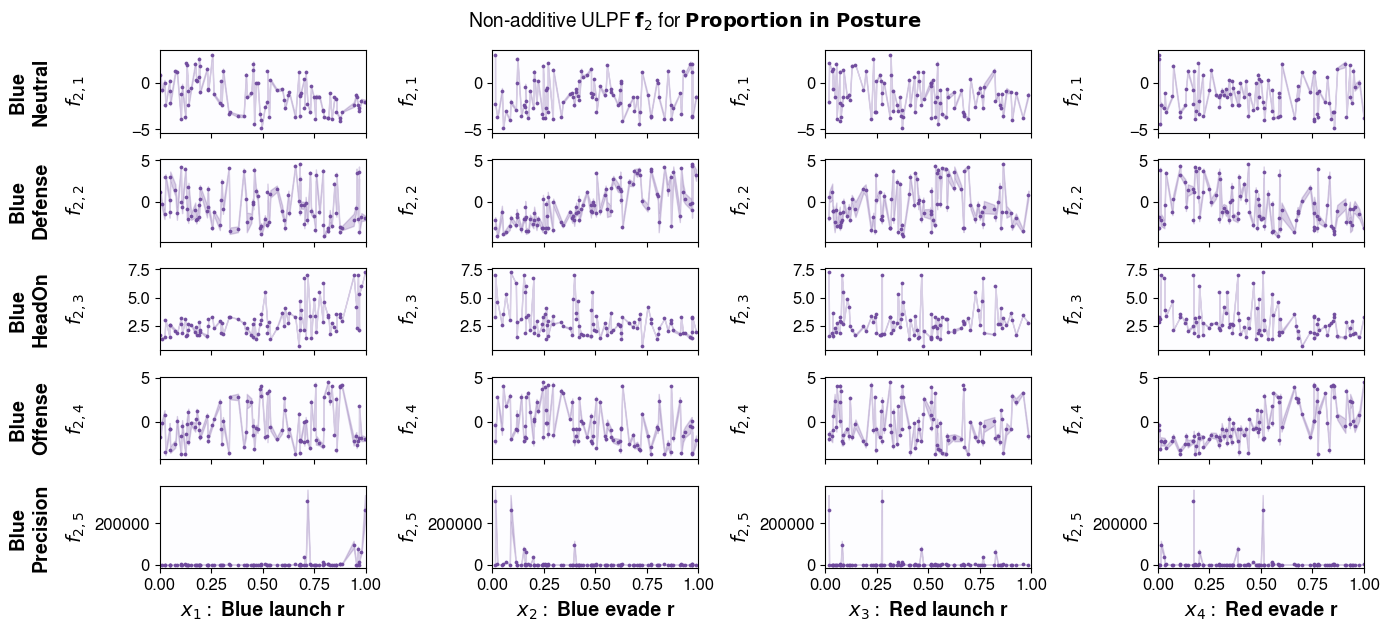

In [139]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, 1, "HetDirichlet", 4, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=None, ulpf=True, row_label=blue_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="blue_composition_hmogp.pdf",)

In [150]:
response_label

['Red \nLaunched']

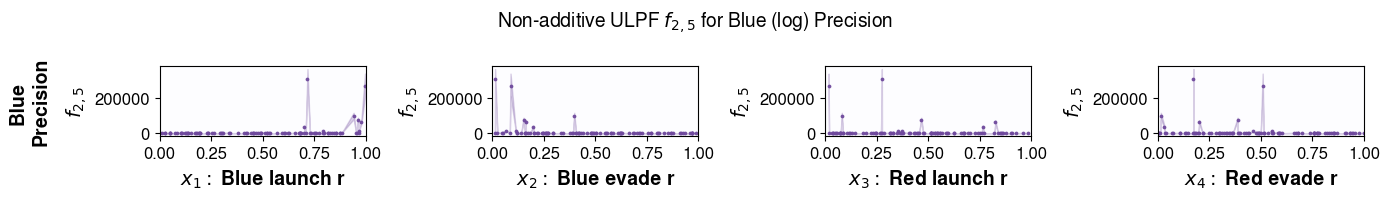

In [167]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"


blue_portion_cols = [
    'Blue \nPrecision'
]

red_portion_cols = [
    'Red \nPrecision'
]

input_set = [
    'Blue launch r',
    'Blue evade r',
    'Red launch r',
    'Red evade r',
]

response_label = r"Blue (log) Precision"

title = r"Non-additive ULPF ${{f}}_{{{},{}}}$".format(2,5)

plot_ahetmogp(train_x, test_x, test_y, 4, "Poisson", 8, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=title, ulpf=True, row_label=blue_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=True, filename="blue_composition_hmogp_subset.pdf",)


# plot_ahetmogp(train_x, test_x, test_y, 4, "Bernoulli", 15, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=None, ulpf=True, row_label=row_label, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="red_launched_hmogp.pdf", height_adj=.15)

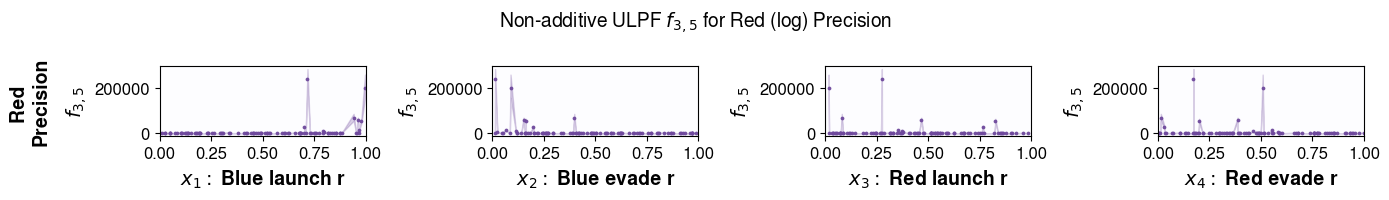

In [171]:
response_label = r"Red (log) Precision"

title = r"Non-additive ULPF ${{f}}_{{{},{}}}$".format(3,5)

plot_ahetmogp(train_x, test_x, test_y, 4, "Poisson", 13, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=title, ulpf=True, row_label=red_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=True, filename="red_composition_hmogp_subset.pdf",)

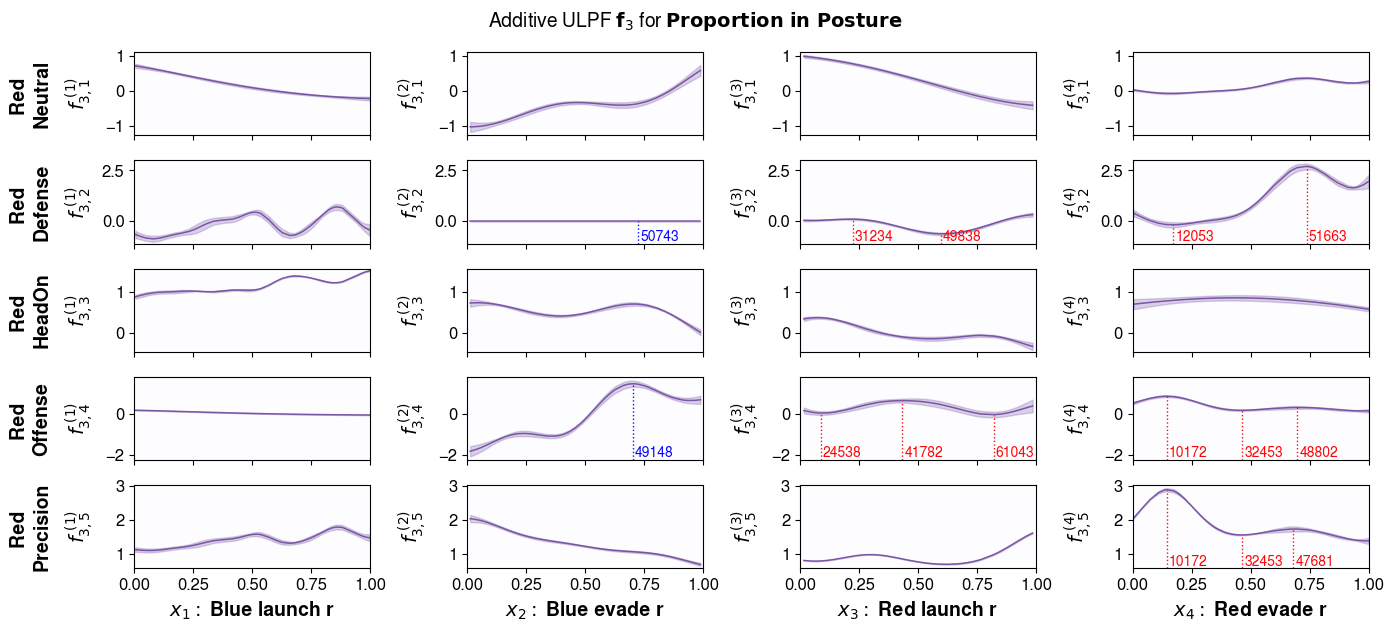

In [141]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"

vlines = {
    "subplot": [
        [1,1], [1,2], [1,3],
        [3,1], [3,2], [3,3],
        [4,1], [4,3],
        ], 
    "transform": [
        blue_briefed_launch_min_max, 
        blue_briefed_evasion_min_max, 
        red_briefed_launch_min_max, 
        red_briefed_evasion_min_max
        ],
    "window": .3,
    # "xticks": xticks
}

plot_ahetmogp(train_x, test_x, test_y, 2, "HetDirichlet", 9, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dim, n_compositions=4, additive=True, title=None, ulpf=True, row_label=red_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="red_composition_sahmogp.pdf", vlines=vlines)

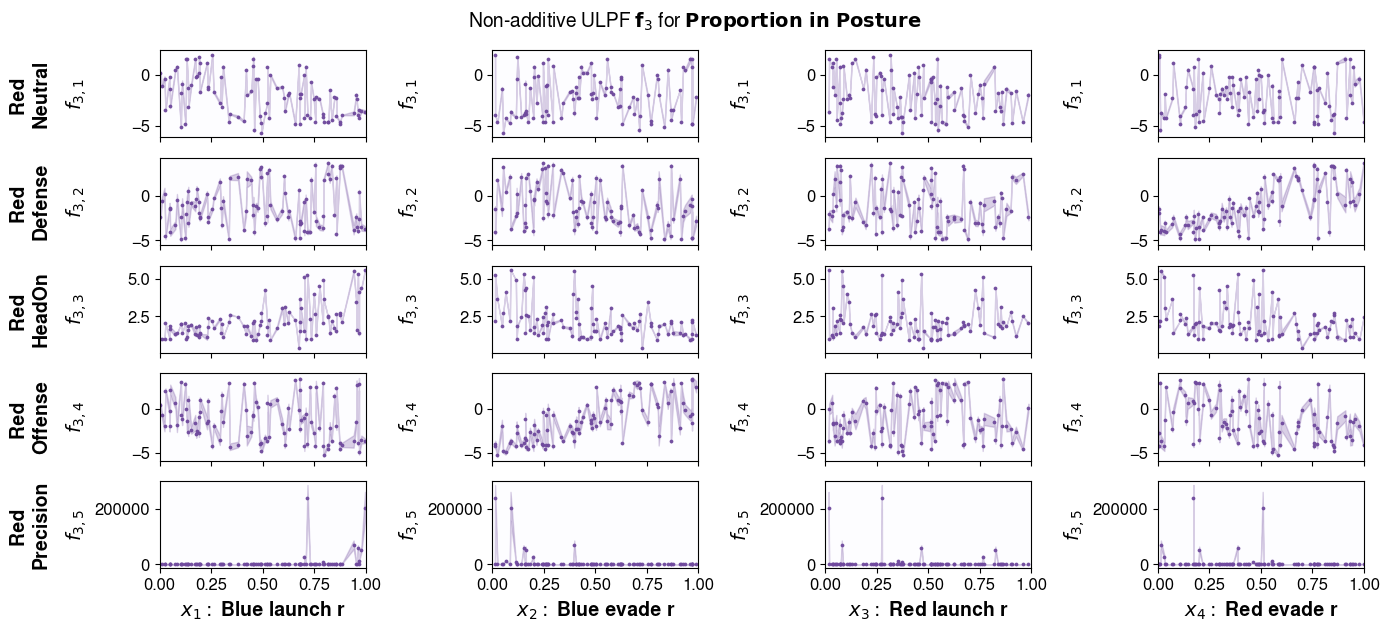

In [142]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, 2, "HetDirichlet", 9, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=None, ulpf=True, row_label=red_portion_cols, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="red_composition_hmogp.pdf",)

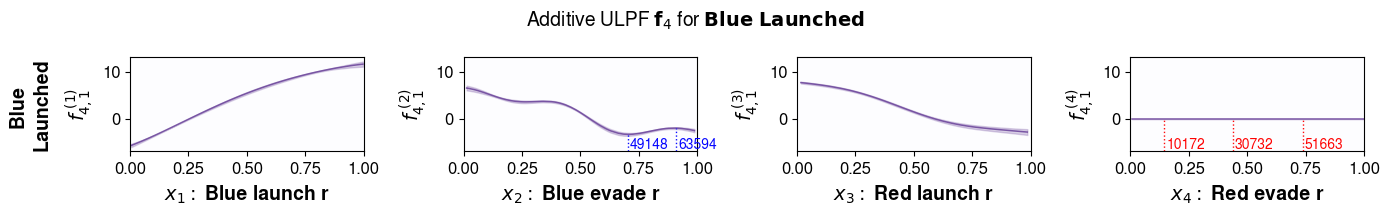

In [143]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"

row_label = ["Blue \nLaunched"]
response_label = r"$\bf{Blue ~ Launched}$"

vlines = {
    "subplot": [
        [0,0], [0,1], [0,2], [0,3],
        ], 
    "transform": [
        blue_briefed_launch_min_max, 
        blue_briefed_evasion_min_max, 
        red_briefed_launch_min_max, 
        red_briefed_evasion_min_max
        ],
    "window": .2,
    # "xticks": xticks
}

plot_ahetmogp(train_x, test_x, test_y, 3, "Bernoulli", 14, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dim, n_compositions=4, additive=True, title=None, ulpf=True, row_label=row_label, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="blue_launched_sahmogp.pdf", vlines=vlines, height_adj=.15)

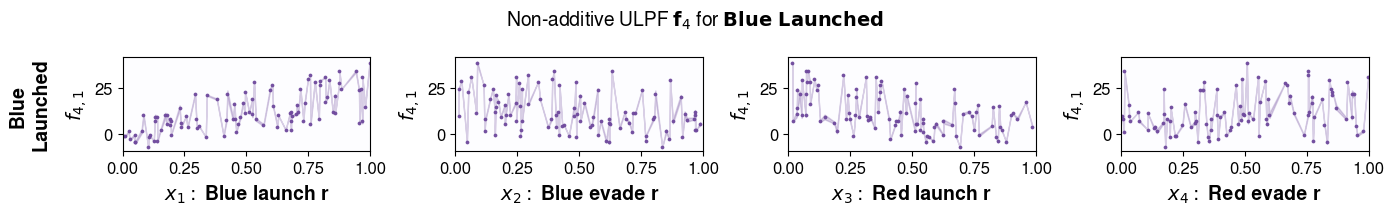

In [144]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"

plot_ahetmogp(train_x, test_x, test_y, 3, "Bernoulli", 14, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=None, ulpf=True, row_label=row_label, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="blue_launched_hmogp.pdf", height_adj=.15)

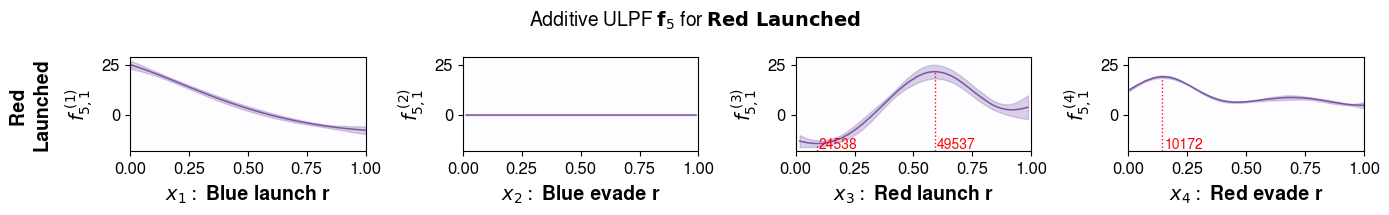

In [145]:

# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
row_label = ["Red \nLaunched"]
response_label = r"$\bf{Red ~ Launched}$"

vlines = {
    "subplot": [
        [0,2], [0,3],
        ], 
    "transform": [
        blue_briefed_launch_min_max, 
        blue_briefed_evasion_min_max, 
        red_briefed_launch_min_max, 
        red_briefed_evasion_min_max
        ],
    "window": 0.5,
    # "xticks": xticks
}

plot_ahetmogp(train_x, test_x, test_y, 4, "Bernoulli", 15, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dim, n_compositions=4, additive=True, title=None, ulpf=True, row_label=row_label, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="red_launched_sahmogp.pdf", vlines=vlines, height_adj=.15)

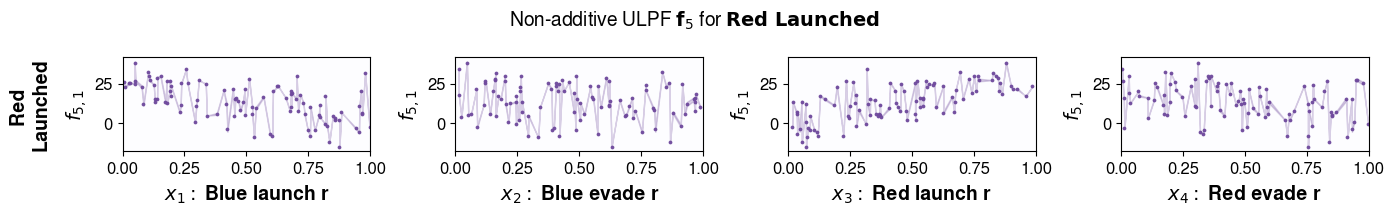

In [146]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, 4, "Bernoulli", 15, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dim_na, n_compositions=4, additive=False, title=None, ulpf=True, row_label=row_label, input_label=input_set, response_label=response_label, plot_obs=False, savefig=False, filename="red_launched_hmogp.pdf", height_adj=.15)

In [53]:
outcome_l = [
    'Red \nWin',
    'Both \nKilled',
    'Both \nSurvived',
    'Blue \nWin', 
    'Blue \nNeutral',
    'Blue \nDefense',
    'Blue \nHeadon', 
    'Blue \nOffense',
    'Blue \nPrecision',
    'Red \nNeutral', 
    'Red \nDefense', 
    'Red \nHeadon', 
    'Red \nOffense',
    'Red \nPrecision',
    "Blue \nLaunched",
    "Red \nLaunched",
]

In [54]:
response_variable = [
    "Outcome",
    "Blue \nNeutral",
    'Blue \nDefense',
    'Blue \nHeadon', 
    'Blue \nOffense',
    'Red \nNeutral', 
    'Red \nDefense', 
    'Red \nHeadon', 
    'Red \nOffense',
    "Blue \nLaunched",
    "Red \nLaunched",
]

corr_data = pd.DataFrame(data=test_y, columns=response_variable)
corr_data = corr_data.corr()

In [55]:
corr_data_ohe = pd.DataFrame(data=test_y, columns=response_variable)
corr_data_ohe.Outcome = corr_data_ohe.Outcome.astype("int") #.astype("category")


outcome_map = {
    0: 'Red \nWin',
    1: 'Both \nKilled',
    2: 'Both \nSurvived',
    3: 'Blue \nWin'
}

corr_data_ohe.Outcome = corr_data_ohe.Outcome.map(outcome_map)
corr_data_ohe = pd.get_dummies(corr_data_ohe, prefix="", prefix_sep="", columns=["Outcome"])
corr_data_ohe = corr_data_ohe.corr()

In [56]:
f_samples_a_mean = f_samples_a.mean(0)

corr = pd.DataFrame(data=f_samples_a_mean, columns=outcome_l)
corr = corr.corr()

In [57]:
D = 5
J_d = [4, 5, 5, 1, 1]
f_dj = []
for d in range(D):
    for j in range(J_d[d]):
        f_dj.append(r'$f_{{~{}, {}}}$'.format(d+1, j+1))

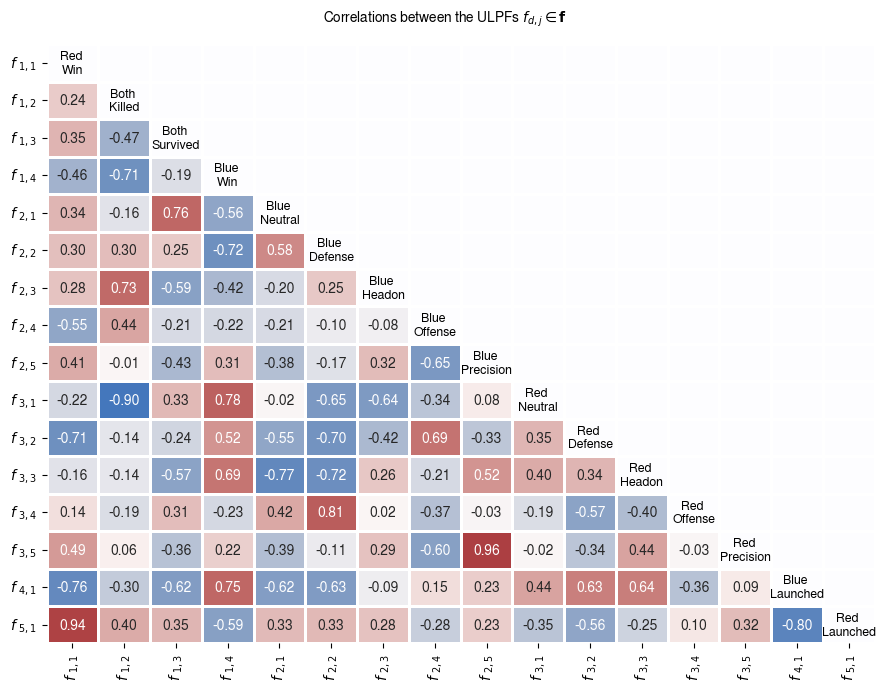

In [58]:
annot_size = 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
# Third heatmap
sns.heatmap(corr, mask=mask, cmap='vlag', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f", 
            linewidths=1, cbar=False, ax=ax, annot_kws={"size": annot_size})
# ax.set_title('Correct correlation method', fontsize=14, weight="bold")
# ticklabels = [r'$f_{{~{}, {}}}$'.format(i+1, i+1) for i in range(4)]
ax.set_xticklabels(f_dj, fontsize=10)
ax.set_yticklabels(f_dj, fontsize=10)
# ax.set_xticklabels(outcome_l)  # Use LaTeX for the x tick labels
# ax.set_yticklabels(outcome_l)  # Use LaTeX for the y tick labelsax.tick_params(axis='both', which='major', labelsize=14)

# Add text annotations to the diagonals
for i in range(len(outcome_l)):
    ax.text(i+0.5, i+0.5, f'{outcome_l[i]}', ha='center', va='center', color='k', fontsize=9)

title = r'Correlations between the ULPFs $f_{{{}, {}}} \in \mathbf{{{}}}$'.format("d", "j", "f")

fig.suptitle(title,  fontsize=10)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"suitable_correlation_method.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

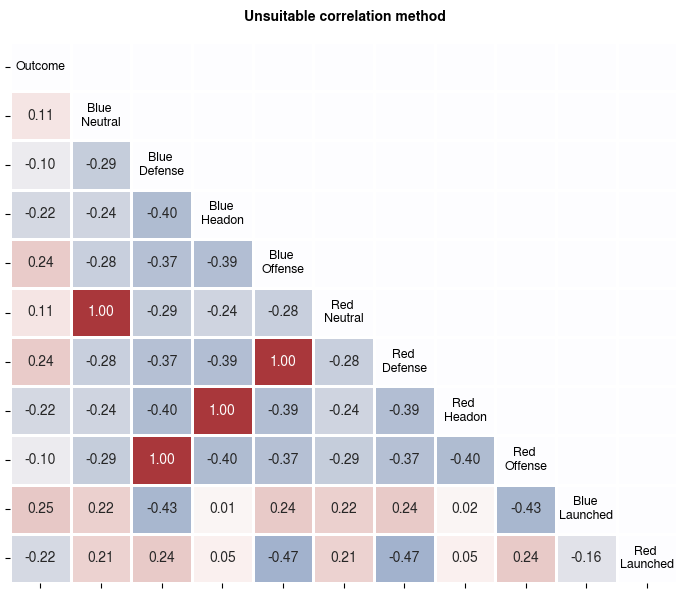

In [59]:
annot_size = 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
# Third heatmap
sns.heatmap(corr_data, mask=mask, cmap='vlag', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f", 
            linewidths=1, cbar=False, ax=ax, annot_kws={"size": annot_size})
# ax.set_title('Correct correlation method', fontsize=14, weight="bold")
# ticklabels = [r'$f_{{~{}, {}}}$'.format(i+1, i+1) for i in range(4)]
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticklabels(outcome_l)  # Use LaTeX for the x tick labels
# ax.set_yticklabels(outcome_l)  # Use LaTeX for the y tick labelsax.tick_params(axis='both', which='major', labelsize=14)

# Add text annotations to the diagonals
for i in range(len(response_variable)):
    ax.text(i+0.5, i+0.5, f'{response_variable[i]}', ha='center', va='center', color='k', fontsize=9)
fig.suptitle("Unsuitable correlation method", weight='bold', fontsize=10)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"unsuitable_correlation_method.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

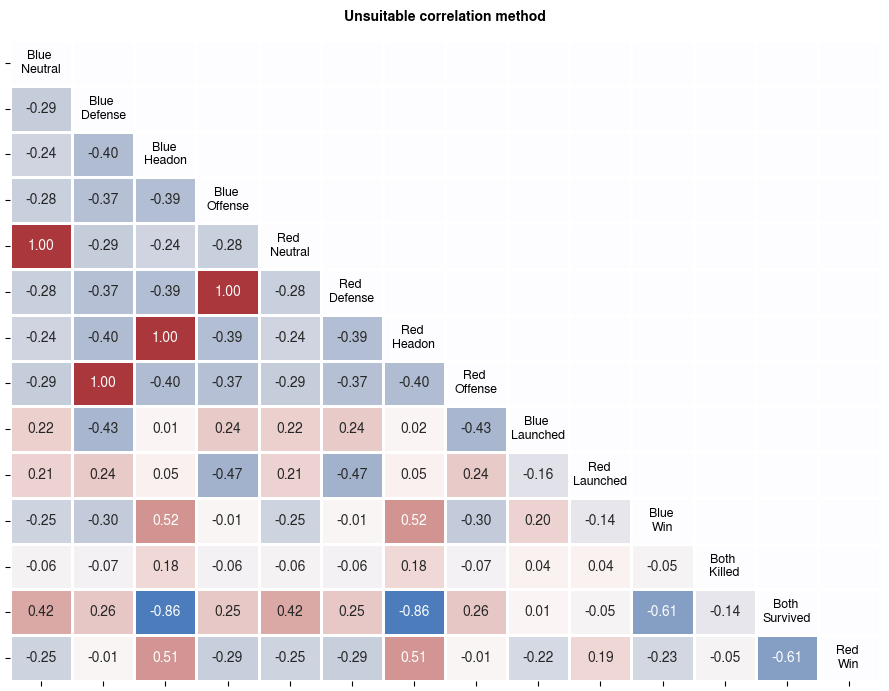

In [60]:
outcome_ohe = corr_data_ohe.columns


annot_size = 10

# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_data_ohe, dtype=bool))
# Third heatmap
sns.heatmap(corr_data_ohe, mask=mask, cmap='vlag', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f", 
            linewidths=1, cbar=False, ax=ax, annot_kws={"size": annot_size})
# ax.set_title('Correct correlation method', fontsize=14, weight="bold")
# ticklabels = [r'$f_{{~{}, {}}}$'.format(i+1, i+1) for i in range(4)]
ax.set_xticklabels([])
ax.set_yticklabels([])
# ax.set_xticklabels(outcome_l)  # Use LaTeX for the x tick labels
# ax.set_yticklabels(outcome_l)  # Use LaTeX for the y tick labelsax.tick_params(axis='both', which='major', labelsize=14)

# Add text annotations to the diagonals
for i in range(len(outcome_ohe)):
    ax.text(i+0.5, i+0.5, f'{outcome_ohe[i]}', ha='center', va='center', color='k', fontsize=9)
fig.suptitle("Unsuitable correlation method", weight='bold', fontsize=10)
fig.tight_layout()

# if savefig:
#     fig.savefig(os.path.join(save_image_path, f"unsuitable_correlation_method.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [61]:
def to_numpy(x):
    if not isinstance(x, np.ndarray):
        x = x.numpy()
    return x

def plot_ppc(y, y_pred, n_samples=None, ax=None, plot_mean=True, **kwargs):

    y = to_numpy(y)
    y_pred = to_numpy(y_pred)
    n_obs = y_pred.shape[-1]

    if not ax:
        fig, ax = plt.subplots(figsize=(4,3))

    if n_samples:
        idx = np.random.choice(y_pred.shape[0], size=n_samples, replace=False)
    else:
        idx = np.arange(y_pred.shape[0])
    
    ax.hlines(0,0,0.0001, color="#6F499D", lw=1.05, label="PPD samples")
    kde0 = sns.kdeplot(y_pred[idx[0]], color="#6F499D", lw=.15, ax=ax, alpha=.20).lines[0].get_data()
    kde_fn = np.empty((idx.shape[0], kde0[1].shape[0]))
    kde_x, kde_fn[0] = kde0
    for i in range(1, len(idx)):
        kde = sns.kdeplot(y_pred[idx[i]], color="#6F499D", lw=.15, ax=ax, alpha=.20).lines[0].get_data()
        kde_fn[i] = kde[1]
    sns.kdeplot(y, color="k", lw=1.15, label="Test data", alpha=.9, ax=ax)

    if plot_mean:
        kde_mean = kde_fn.mean(0)
        sns.lineplot(x=kde_x, y=kde_mean, color="#ff7f0e", lw=1.05, linestyle="--", label="PPD mean", alpha=.9, ax=ax)
        
    # ax.spines[['right', 'top']].set_visible(False)
    # ax.set_yticks([])
    # ax.set_ylabel("")

    # ax.legend(fontsize=9)

    if not ax:
        fig.tight_layout()

In [62]:
def plot_ppc_comparison(y, y_pred1, y_pred2, row_label=None, col_label=None, discrete=False, xticklabels=None, xlim=False, savefig=False, **kwargs):

    y = to_numpy(y)
    y_pred1 = to_numpy(y_pred1)
    y_pred2 = to_numpy(y_pred2)
    
    if y.ndim == 1:
        nrows = 1
    else:
        nrows = y.shape[-1]
    ncols = 2
    width = 3.5*ncols
    height = .9 + 1.5*nrows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                           figsize=(width,height), sharey=False, sharex=False)

    if nrows == 1:
        ax = ax[None,]
        y = y[...,None]
        y_pred1 = y_pred1[...,None]
        y_pred2 = y_pred2[...,None]
    
    for i in range(nrows):
        for j in range(ncols):
            if j == 0:
                y_pred = y_pred1[...,i]
            else:
                y_pred = y_pred2[...,i]
            plot_ppc(y[:,i], y_pred, ax=ax[i,j], **kwargs)

    ymax = np.repeat(-np.inf, nrows)

    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].set_yticks([])
            if (j == 0) and row_label:
                ax[i,j].set_ylabel(row_label[i], rotation=90, fontsize=9, 
                                ha="center", labelpad=7.5)
            else:
                ax[i,j].set_ylabel("")
            
            if (i == 0) and col_label:
                ax[i,j].set_title(col_label[j], rotation=0, fontsize=9, 
                                ha="center", pad=6)
                
            ymax_ = ax[i,j].get_ylim()[1]
            if ymax_ > ymax[i]:
                ymax[i] = ymax_

    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].set_ylim(0, ymax[i])
            ax[i,j].tick_params(axis='both', which='major', labelsize=8)
            if discrete:
                xticks = np.unique(y)
                ax[i,j].set_xticks(xticks)
                if xticklabels is not None:
                    ax[i,j].set_xticklabels(xticklabels)   
            elif xticklabels is not None:
                ax[i,j].set_xticks(xticklabels)
            if ax[i,j].get_legend():
                ax[i,j].get_legend().remove()
    ax.flatten()[-2].legend(fontsize=8)        
    fig.align_ylabels(ax)
    fig.tight_layout()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] in [".pdf", ".png"])
        if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
            os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
            print("Deleted file:", filename[:-4] + ".png")
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

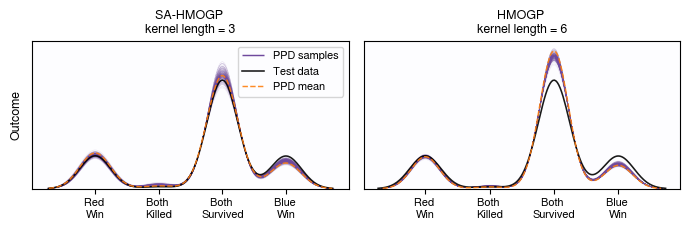

In [63]:
row_label = [
    "Outcome"
]

col_label = [
    "SA-HMOGP \nkernel length = 3",
    "HMOGP \nkernel length = 6",
]

outcome = [
    "Red \nWin",
    "Both \nKilled",
    "Both \nSurvived",
    "Blue \nWin",
]

plot_ppc_comparison(test_y[:,0], y_pred_a[0][:,0,:], y_pred_na[0][:,0,:],
                    col_label=col_label,
                    row_label=row_label,
                    discrete=True,
                    xticklabels=outcome,
                    n_samples=300,
                    savefig=False, 
                    filename="outcome_ppc.pdf",)

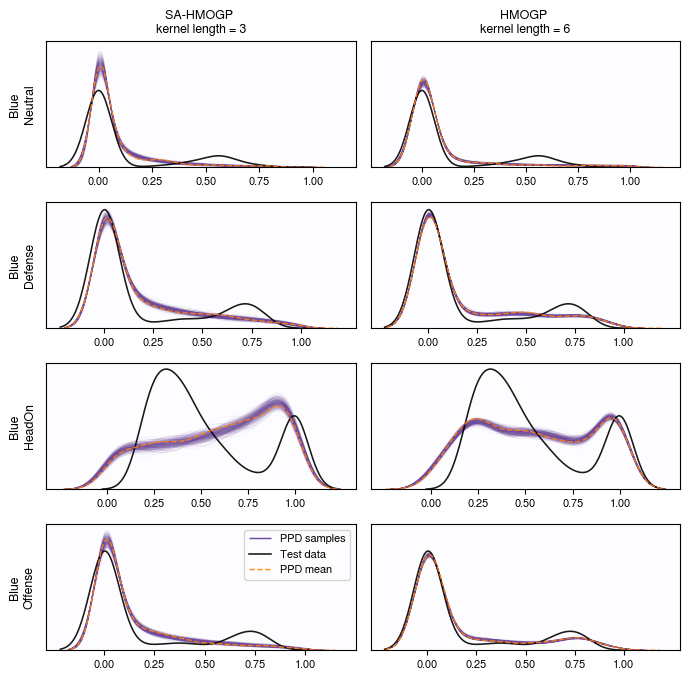

In [64]:
row_label = [
    'Blue \nNeutral', 
    'Blue \nDefense',
    'Blue \nHeadOn', 
    'Blue \nOffense',
]

col_label = [
    "SA-HMOGP \nkernel length = 3",
    "HMOGP \nkernel length = 6",
]

plot_ppc_comparison(test_y[:,1:5], y_pred_a[1][:,0,:,:], y_pred_na[1][:,0,:,:],
                    col_label=col_label,
                    row_label=row_label,
                    xticklabels=np.linspace(0,1,5),
                    n_samples=300,
                    savefig=False, 
                    filename="blue_composition_ppc.pdf",)

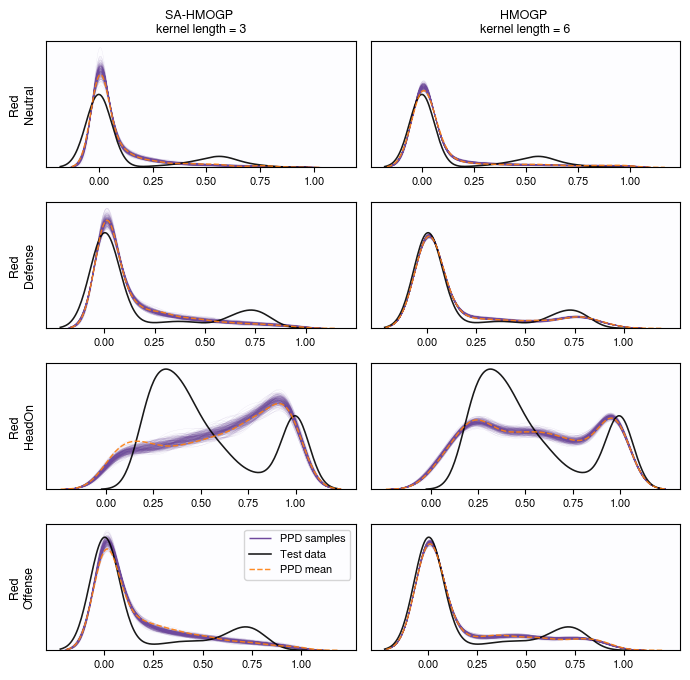

In [65]:
row_label = [
    'Red \nNeutral', 
    'Red \nDefense',
    'Red \nHeadOn', 
    'Red \nOffense',
]

col_label = [
    "SA-HMOGP \nkernel length = 3",
    "HMOGP \nkernel length = 6",
]

plot_ppc_comparison(test_y[:,5:9], y_pred_a[2][:,0,:,:], y_pred_na[2][:,0,:,:],
                    col_label=col_label,
                    row_label=row_label,
                    xticklabels=np.linspace(0,1,5),
                    n_samples=300,
                    savefig=False, 
                    filename="red_composition_ppc.pdf",)

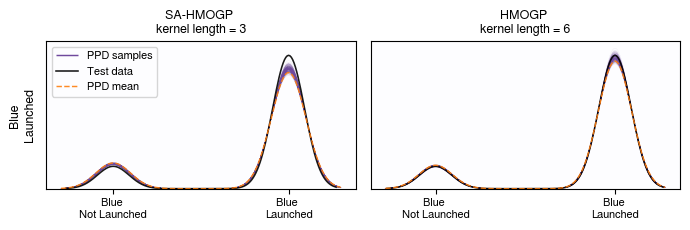

In [66]:
row_label = [
    'Blue \nLaunched', 
]

col_label = [
    "SA-HMOGP \nkernel length = 3",
    "HMOGP \nkernel length = 6",
]

outcome = [
    'Blue \nNot Launched', 
    'Blue \nLaunched', 
]

plot_ppc_comparison(test_y[:,9], y_pred_a[3][:,0,:], y_pred_na[3][:,0,:],
                    col_label=col_label,
                    row_label=row_label,
                    discrete=True,
                    xticklabels=outcome,
                    n_samples=300,
                    savefig=False, 
                    filename="blue_launched_ppc.pdf",)

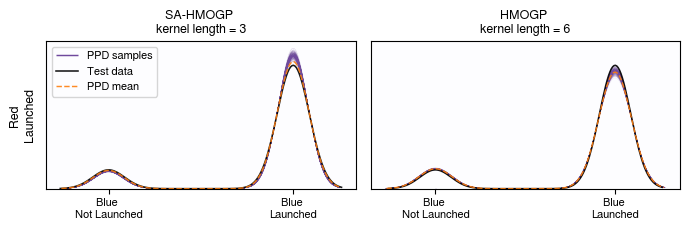

In [67]:

row_label = [
    'Red \nLaunched', 
]

col_label = [
    "SA-HMOGP \nkernel length = 3",
    "HMOGP \nkernel length = 6",
]

outcome = [
    'Blue \nNot Launched', 
    'Blue \nLaunched', 
]

plot_ppc_comparison(test_y[:,10], y_pred_a[4][:,0,:], y_pred_na[4][:,0,:],
                    col_label=col_label,
                    row_label=row_label,
                    discrete=True,
                    xticklabels=outcome,
                    n_samples=300,
                    savefig=False, 
                    filename="red_launched_ppc.pdf",)

In [6]:
testtesttest = torch.randn(3, 3)
testtesttest

tensor([[ 0.9735,  2.2364, -0.4590],
        [ 0.9236, -1.2346,  0.0244],
        [-0.5152,  1.0960, -0.0466]])

In [7]:
testtesttest[0]

tensor([ 0.9735,  2.2364, -0.4590])

In [2]:
import dill
# dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')

In [53]:
def plot_agreement_weights(cm1, cm2, labels=None, savefig=False, **kwargs):

    n_categories = cm1.shape[0]
    width = 3.5 * 2
    height = .9 + 1.1*1 + .90 + .25*n_categories
    cm_list = [cm1, cm2]

    fig, ax = plt.subplots(ncols=2, figsize=(width, height))

    for i, cm in enumerate(cm_list):
        
        if i == 0:
            subtitle = "Unweighted"
        else:
            subtitle = "Quadratically weighted"
        
        ax[i].matshow(cm, cmap=plt.cm.Greens, alpha=0.3)
        for ii in range(cm.shape[0]):
            for jj in range(cm.shape[1]):
                ax[i].text(x=jj, y=ii,s=cm[ii, jj], va='center', ha='center', size=10)
        ax[i].tick_params(axis='both', which='major', labelsize=9)         
        ax[i].set_title(subtitle, fontsize=9, weight='bold')
        # ax[i].set_ylabel("True", fontsize=9)
        ax[i].xaxis.set_ticks_position('bottom')
        # ax[i].set_xlabel(f"\nPredicted \nScott's Pi:", fontsize=9)
        
        if labels:
            ax[i].set_yticks(np.arange(len(labels)))
            ax[i].set_yticklabels(labels)
            ax[i].set_xticks(np.arange(len(labels)))
            ax[i].set_xticklabels(labels)
    
    fig.tight_layout()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".pdf") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [36]:
cm = np.arange(16).reshape((4,4))
weighted_matrix, _ = scotts_pi(cm, weight_type="quadratic", return_weights=True)
unweighted_matrix, _ = scotts_pi(cm, weight_type="unweighted", return_weights=True)
weighted_matrix = np.round(weighted_matrix,2)
unweighted_matrix = np.round(unweighted_matrix,2)

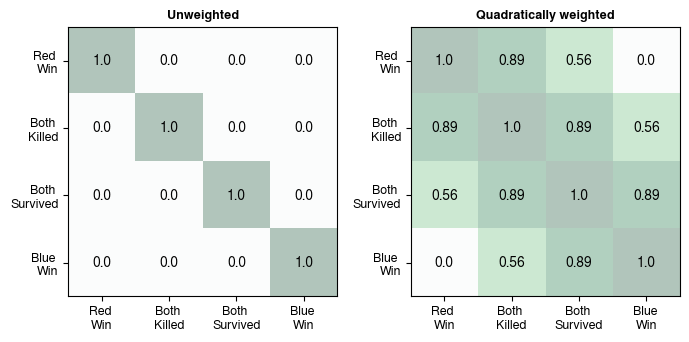

In [38]:
outcome = [
    "Red \nWin",
    "Both \nKilled",
    "Both \nSurvived",
    "Blue \nWin",
]
plot_agreement_weights(unweighted_matrix, weighted_matrix, labels=outcome, savefig=False, filename="weight_agreement_comparison.pdf")